In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import os

# Preprocessing

In [22]:
def binarize(img):
    img = image.img_to_array(img, dtype='uint8')
    binarized = np.expand_dims(cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2), -1)
    inverted_binary_img = ~binarized
    return inverted_binary_img

data_dir = '../data'
batch_size = 32
img_height = 45
img_width = 45

# Creating Training and Validation Datasets

In [23]:
# Create a list of valid class folders (excluding .ipynb_checkpoints)
class_folders = [d for d in os.listdir(data_dir) 
                if os.path.isdir(os.path.join(data_dir, d)) 
                and d != ".ipynb_checkpoints"]

# Setup the generators with validation split and specific classes
datagen = ImageDataGenerator(
    preprocessing_function=binarize,
    validation_split=0.2
)

# Create training generator with specific classes
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='training',
    classes=class_folders,  # Specify valid classes here
    seed=123
)

# Create validation generator with the same class list
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset='validation',
    classes=class_folders,  # Use same class list
    seed=123
)

# Print information about the splits
print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {validation_generator.samples}")
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Class mapping: {train_generator.class_indices}")

Found 27983 images belonging to 14 classes.
Found 6988 images belonging to 14 classes.
Number of training samples: 27983
Number of validation samples: 6988
Number of classes: 14
Class mapping: {'0': 0, 'times': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '+': 11, '-': 12, '=': 13}


# Creating Classification Model

In [24]:
num_classes = 14

model = tf.keras.Sequential([
  tf.keras.layers.Input((45, 45, 1)),
  tf.keras.layers.Rescaling(1./255), # originally tf.keras.layers.Rescaling
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 45, 45, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 43, 43, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        36,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │         1,806 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,614 (225.05 KB)

 Trainable params: 57,614 (225.05 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# Train the model with validation data
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # adjust as needed
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
)

Epoch 1/20


/home/ayyildi1/.local/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


875/875 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.7513 - loss: 0.8171 - val_accuracy: 0.9536 - val_loss: 0.1819 - learning_rate: 0.0010
Epoch 2/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9608 - loss: 0.1396 - val_accuracy: 0.9565 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 3/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9767 - loss: 0.0839 - val_accuracy: 0.9662 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 4/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9809 - loss: 0.0668 - val_accuracy: 0.9717 - val_loss: 0.1156 - learning_rate: 0.0010
Epoch 5/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 30s 34ms/step - accuracy: 0.9883 - loss: 0.0458 - val_accuracy: 0.9710 - val_loss: 0.1095 - learning_rate: 0.0010
Epoch 6/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 28s 32ms/step - accuracy: 0.9889 - loss: 0.0383 - val_accuracy: 0.9782 - val_loss: 0.0999 - learning_rate: 0.0010
Epoch 7/20
875/875 ━━━━━━━━━━━━━━━━━━━━ 29s 33ms/step - accuracy: 0.9907 - loss: 0.0299

# Creating Plots

In [28]:
# Get class names from the generator's class mapping
class_mapping = train_generator.class_indices  # This is a dictionary like {'0': 0, 'times': 1, ...}
class_names = [k for k,v in sorted(class_mapping.items(), key=lambda x: x[1])]

# Print to verify
print("Class names:", class_names)
print("Number of classes:", len(class_names))

Class names: ['0', 'times', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '=']
Number of classes: 14


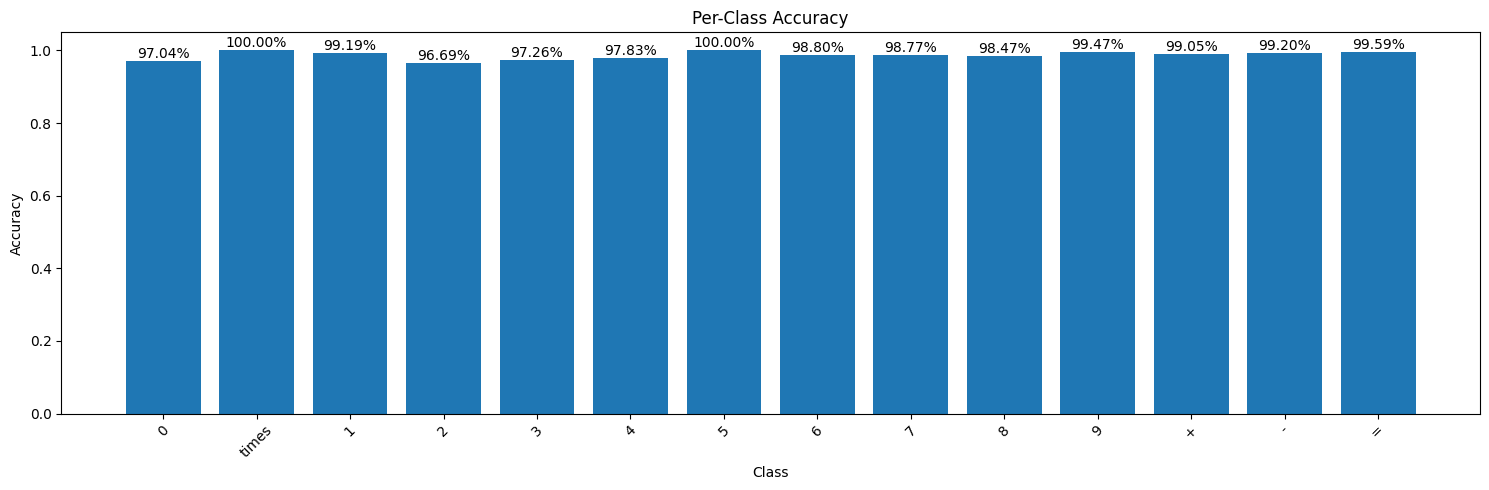

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Data
class_names = ['0', 'times', '1', '2', '3', '4', '5', '6', '7', '8', '9', '+', '-', '=']
accuracies = np.array([97.04, 100, 99.19, 96.69, 97.26, 97.83, 100, 98.80, 98.77, 98.47, 99.47, 99.05, 99.20, 99.59])

# Convert accuracies to 0-1 scale for plotting
accuracies_scaled = accuracies / 100

# Create the plot
plt.figure(figsize=(15, 5))
bars = plt.bar(class_names, accuracies_scaled)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)

# Add percentage labels on top of bars using the original accuracy values
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{acc:.2f}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

def visualize_model_performance(model, validation_generator, history, class_names):
    """Generate and display all visualizations in the notebook"""
    
    # 1. Training History Plots
    plt.figure(figsize=(15, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Get predictions
    validation_generator.reset()
    all_preds = []
    all_labels = []
    all_pred_probs = []
    
    steps = len(validation_generator)
    for i in range(steps):
        batch_x, batch_y = next(validation_generator)
        batch_pred = model.predict(batch_x, verbose=0)
        
        all_pred_probs.extend(batch_pred)
        all_preds.extend(np.argmax(batch_pred, axis=1))
        all_labels.extend(np.argmax(batch_y, axis=1))
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_pred_probs = np.array(all_pred_probs)
    
    # 2. Confusion Matrix
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
    
    # 3. Per-class Accuracy
    accuracies = []
    for i in range(len(class_names)):
        mask = all_labels == i
        if mask.sum() > 0:
            acc = (all_preds[mask] == i).mean()
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    plt.figure(figsize=(15, 5))
    bars = plt.bar(class_names, accuracies)
    plt.title('Per-Class Accuracy')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    # 4. Prediction Confidence Distribution
    confidences = np.max(all_pred_probs, axis=1)
    correct = all_preds == all_labels
    
    plt.figure(figsize=(10, 6))
    plt.hist([confidences[correct], confidences[~correct]], 
             label=['Correct', 'Incorrect'], 
             bins=30, alpha=0.7)
    plt.title('Distribution of Prediction Confidence')
    plt.xlabel('Confidence')
    plt.ylabel('Count')
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 5. Print Classification Report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    
    # 6. Print Overall Accuracy
    accuracy = np.mean(all_preds == all_labels)
    print(f"\nOverall Accuracy: {accuracy:.4f}")


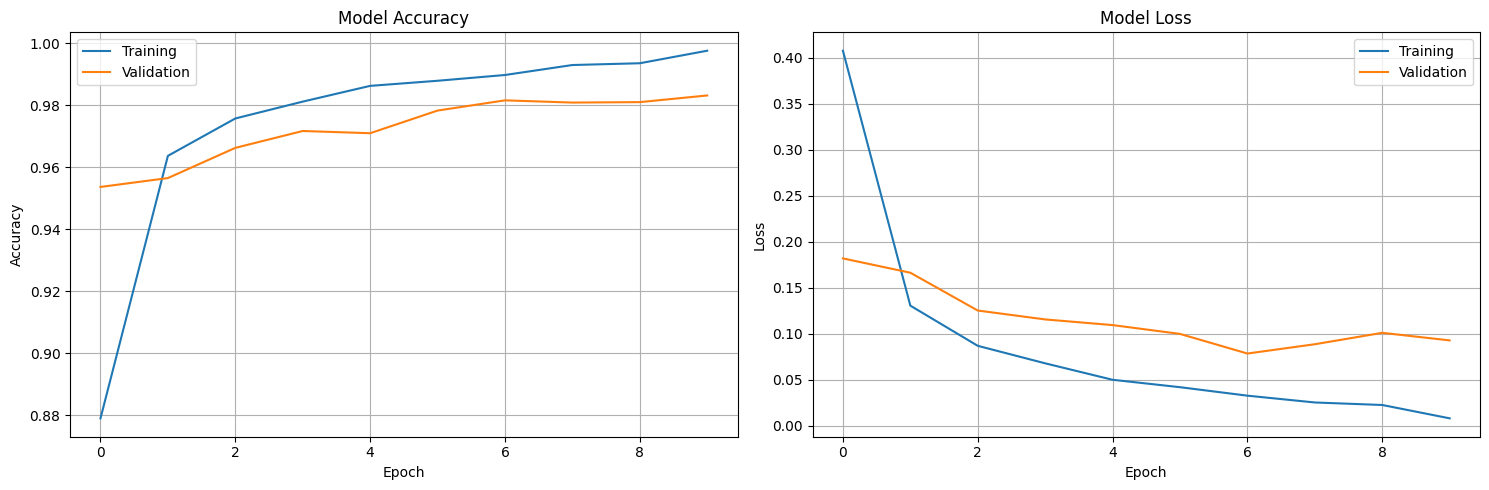

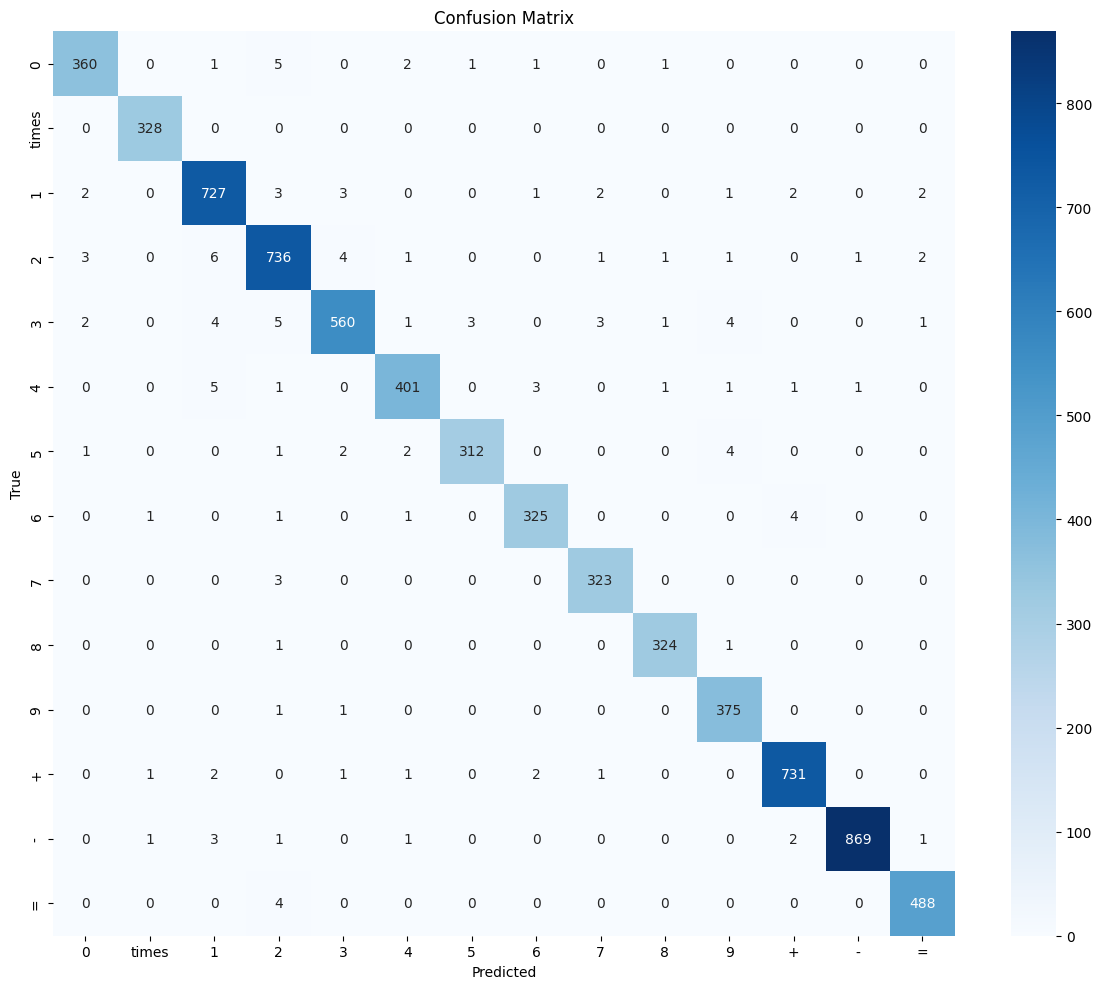

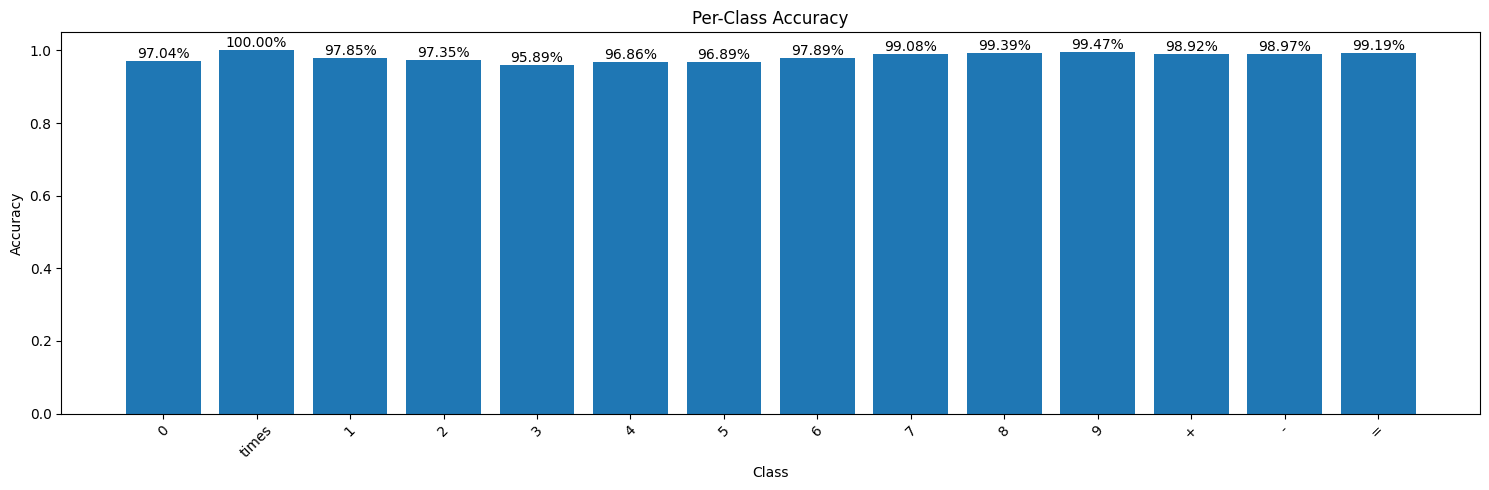

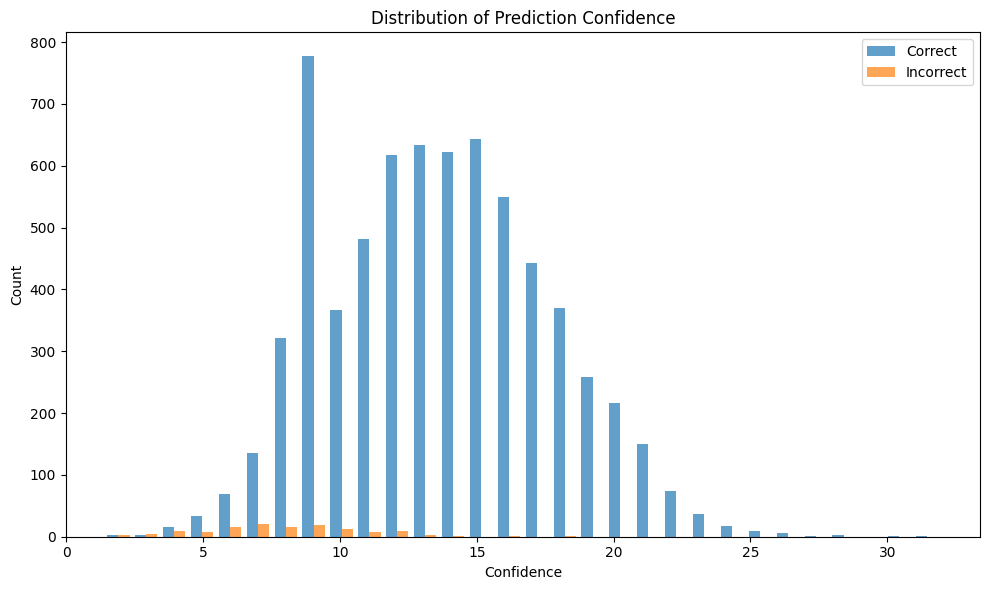


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       371
       times       0.99      1.00      1.00       328
           1       0.97      0.98      0.98       743
           2       0.97      0.97      0.97       756
           3       0.98      0.96      0.97       584
           4       0.98      0.97      0.97       414
           5       0.99      0.97      0.98       322
           6       0.98      0.98      0.98       332
           7       0.98      0.99      0.98       326
           8       0.99      0.99      0.99       326
           9       0.97      0.99      0.98       377
           +       0.99      0.99      0.99       739
           -       1.00      0.99      0.99       878
           =       0.99      0.99      0.99       492

    accuracy                           0.98      6988
   macro avg       0.98      0.98      0.98      6988
weighted avg       0.98      0.98      0.98      6988




In [31]:
visualize_model_performance(model, validation_generator, history, class_names)

Verified accuracy: 0.9828


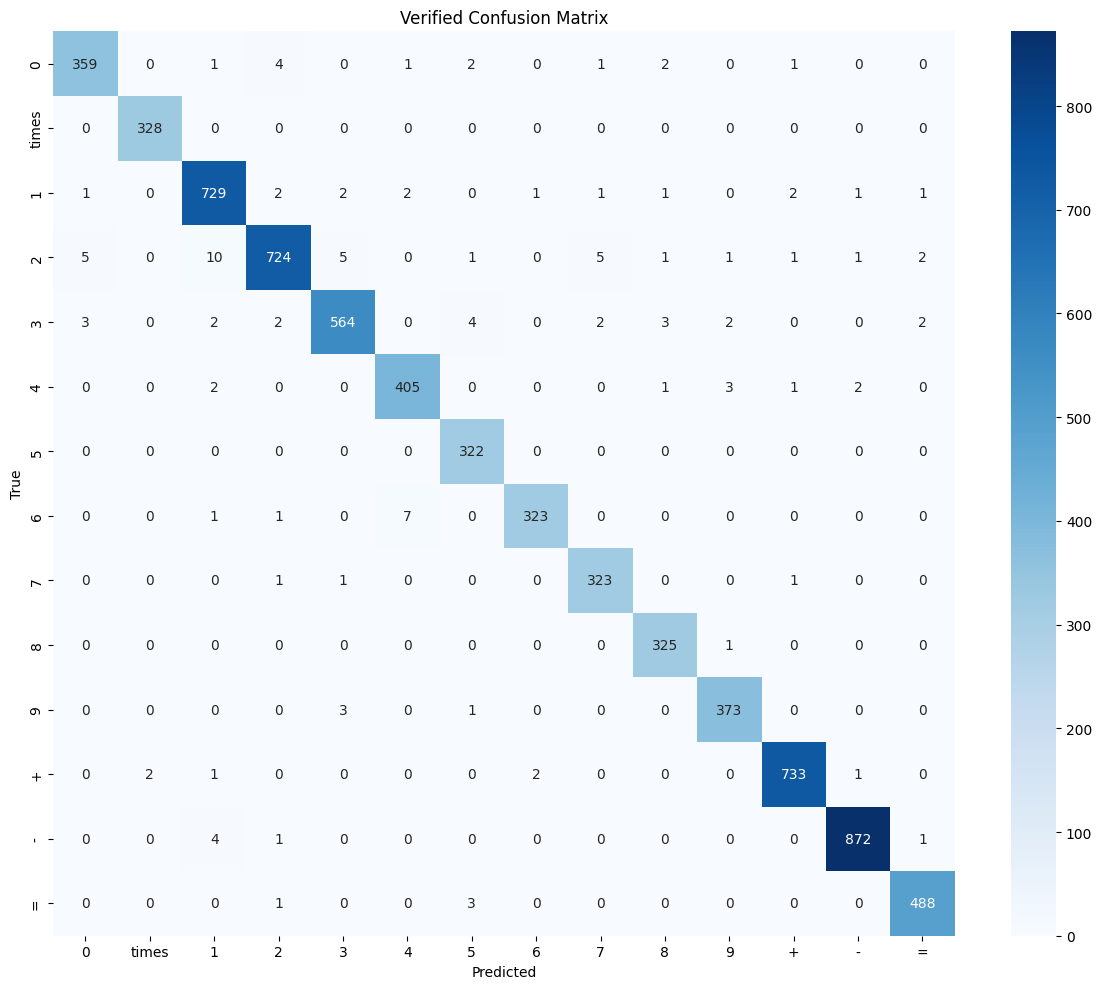

In [18]:
def verify_predictions(model, generator, class_names):
    # Reset generator to start
    generator.reset()
    
    # Collect all predictions and true labels
    all_preds = []
    all_labels = []
    
    steps = len(generator)
    for i in range(steps):
        batch_x, batch_y = next(generator)
        batch_pred = model.predict(batch_x, verbose=0)
        
        all_preds.extend(np.argmax(batch_pred, axis=1))
        all_labels.extend(np.argmax(batch_y, axis=1))
        
    # Calculate accuracy
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Verified accuracy: {accuracy:.4f}")
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title('Verified Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

verify_predictions(model, validation_generator, class_names)

# Object Detection Using Contours

In [40]:
image_dir = "test_equation_images/"

In [41]:
def getOverlap(a, b):
     return max(0, min(a[1], b[1]) - max(a[0], b[0]))
def detect_contours(img_path):
    # Given an image path, output bounding box coordinates of an image
    input_image = cv2.imread(img_path, 0) # Load a greyscale image
 
    # Make a copy to draw bounding box
    input_image_cpy = input_image.copy()

    # Convert the grayscale image to binary (image binarization opencv python), then invert
    binarized = cv2.adaptiveThreshold(input_image_cpy,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,11,2)
    inverted_binary_img = ~binarized

    # Detect contours
    # hierarchy variable contains information about the relationship between each contours
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE) # Find contours
    # Detect contours
    l = []
    for c in contours_list:
        x, y, w, h = cv2.boundingRect(c)
        l.append([x, y, w, h])
    # Check whether any overlapping rectangles. We do this in a way such that we only compare each box once with all other boxes.
    lcopy = l.copy()
    keep = []
    while len(lcopy) != 0:
        curr_x, curr_y, curr_w, curr_h = lcopy.pop(0) # Look at next box
        if curr_w * curr_h < 20: # remove very small boxes
            continue
        throw = []
        for i, (x, y, w, h) in enumerate(lcopy):
            curr_interval = [curr_x, curr_x+curr_w]
            next_interval = [x, x+w]
            if getOverlap(curr_interval, next_interval) > 1 : # more than 3 pixels overlap, this is arbitrary
                # Merge the two intervals
                new_interval_x = [min(curr_x, x), max(curr_x+curr_w, x+w)]
                new_interval_y = [min(curr_y, y), max(curr_y+curr_h, y+h)]
                newx, neww = new_interval_x[0], new_interval_x[1] - new_interval_x[0]
                newy, newh = new_interval_y[0], new_interval_y[1] - new_interval_y[0]
                curr_x, curr_y, curr_w, curr_h = newx, newy, neww, newh
                throw.append(i) # Mark this box to throw away later, since it has now been merged with current box
        for ind in sorted(throw, reverse=True): # Sort in reverse order otherwise we will pop incorrectly
            lcopy.pop(ind)
        keep.append([curr_x, curr_y, curr_w, curr_h]) # Keep the current box we are comparing against
    return keep

In [42]:
IMAGE = "2numbers_test_000.png"
img_path = "test_equation_images/"+IMAGE
input_image = cv2.imread(img_path, 0) 
input_image_cpy = input_image.copy()
keep = detect_contours(image_dir+IMAGE)

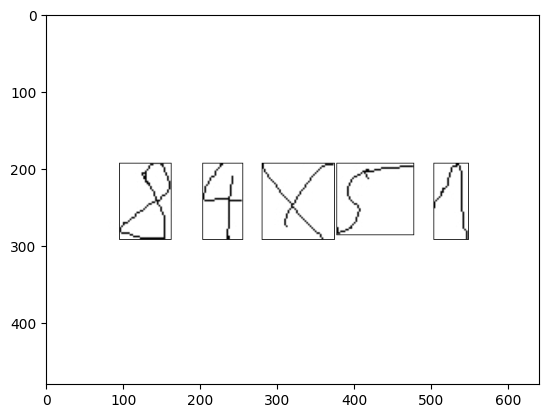

In [43]:
#Visualise how the bounding boxes look like
for (x, y, w, h) in keep:
    cv2.rectangle(input_image_cpy, (x, y), (x + w, y + h), (0, 0, 255), 1)
plt.imshow(input_image_cpy, cmap='gray')
plt.show()

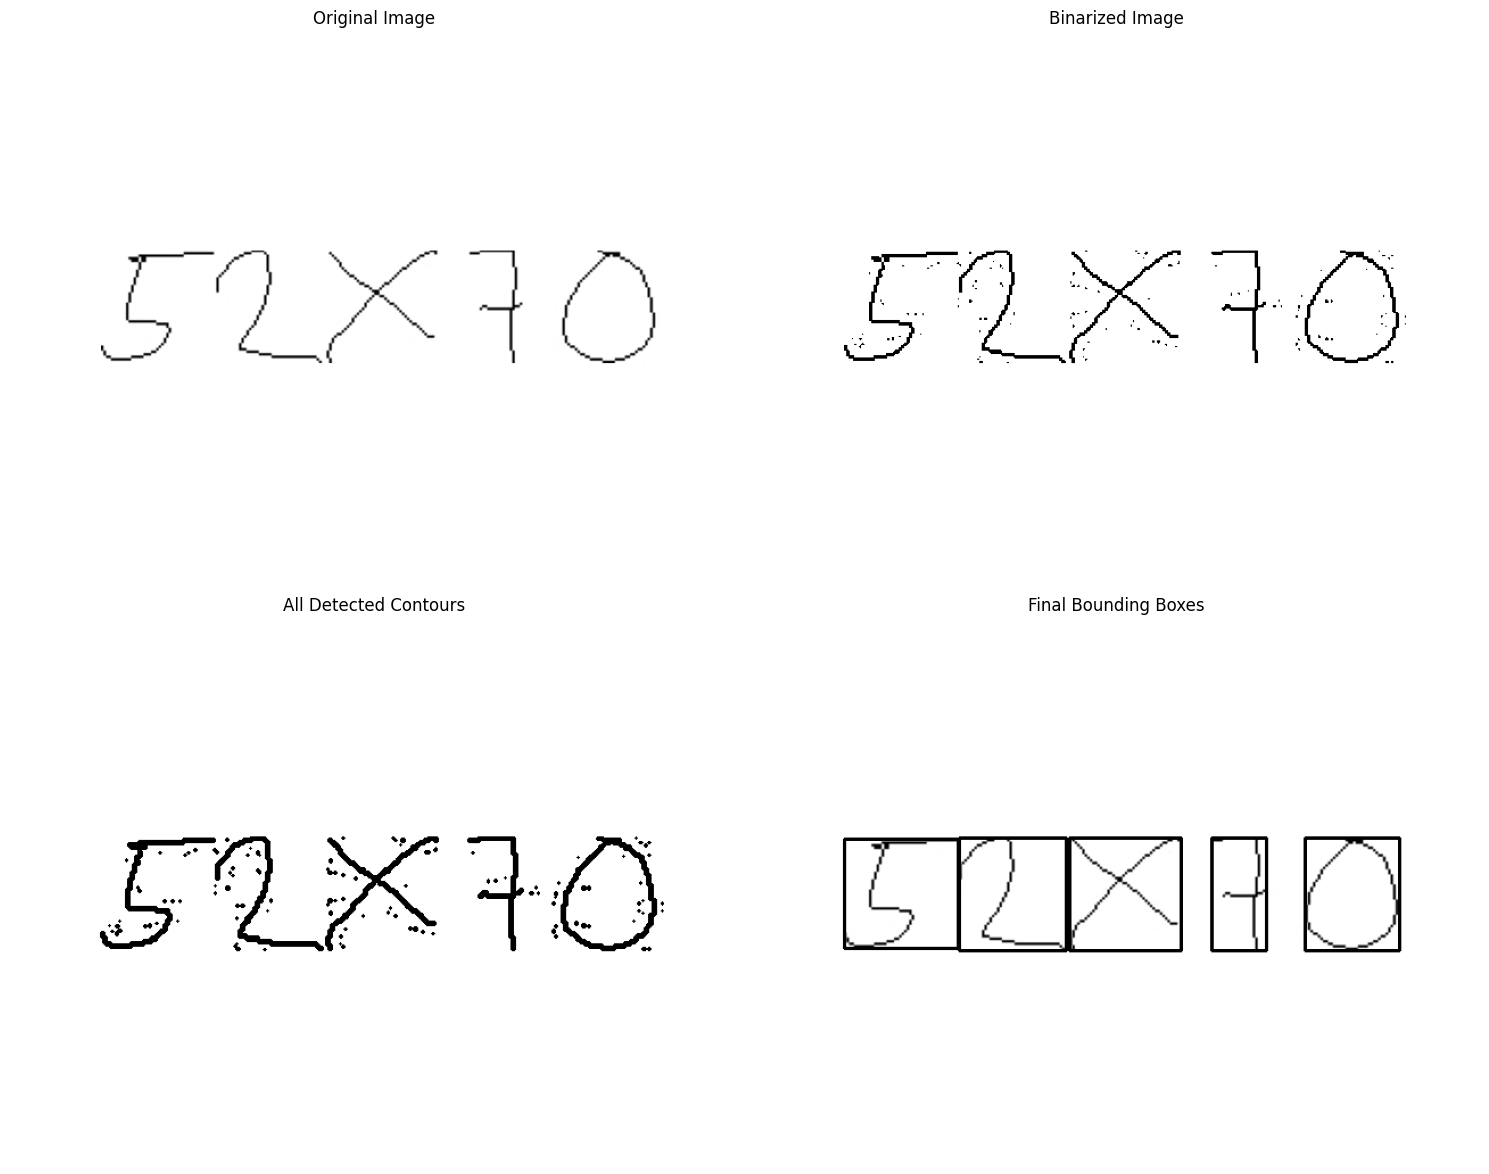

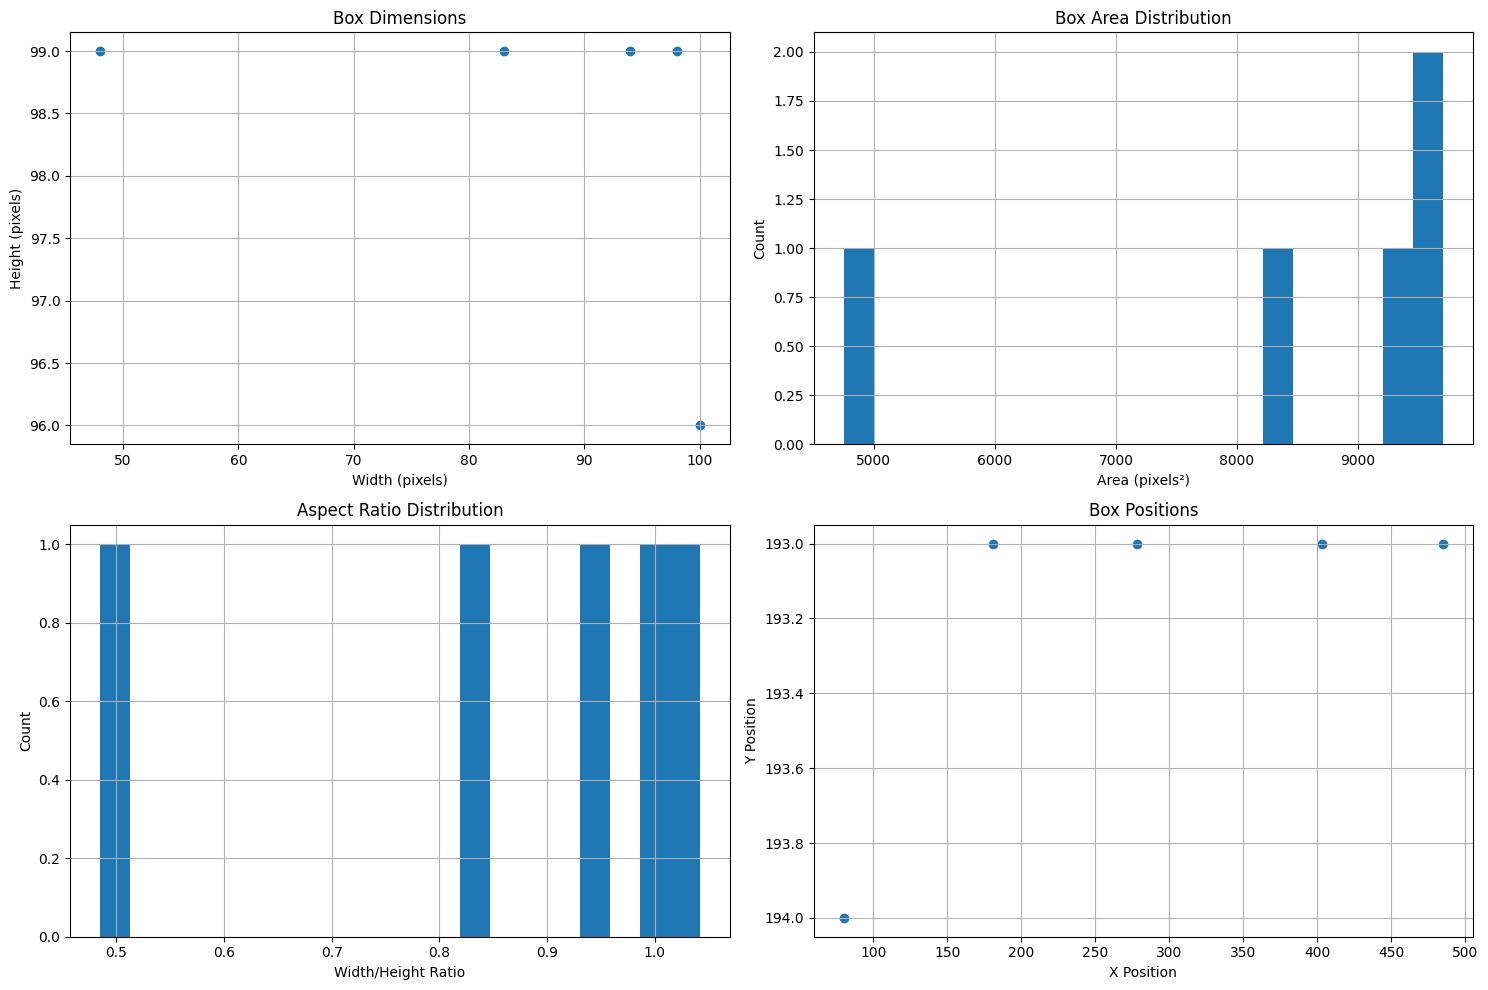

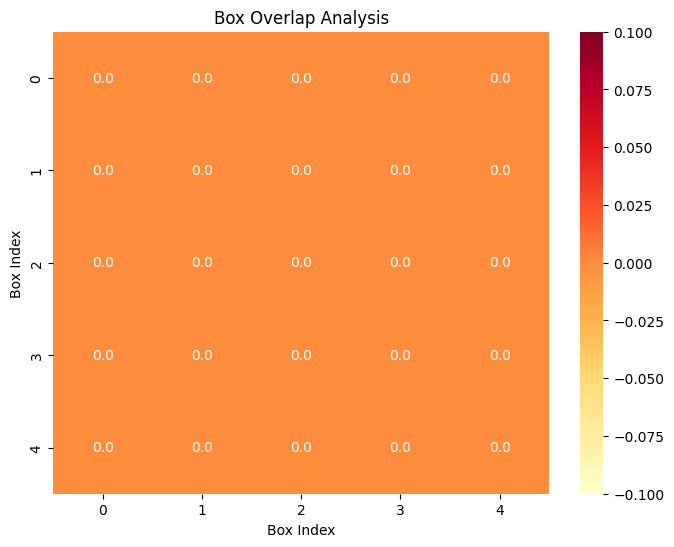

In [45]:
def create_contour_visualizations(image_path):
    """Create comprehensive visualizations of the contour detection process"""
    # Read image and process
    input_image = cv2.imread(image_path, 0)
    binarized = cv2.adaptiveThreshold(input_image, 255, 
                                    cv2.ADAPTIVE_THRESH_MEAN_C, 
                                    cv2.THRESH_BINARY, 11, 2)
    inverted_binary_img = ~binarized
    
    # Get contours and boxes
    contours_list, hierarchy = cv2.findContours(inverted_binary_img,
                                              cv2.RETR_TREE,
                                              cv2.CHAIN_APPROX_SIMPLE)
    
    # Get final boxes
    keep = detect_contours(image_path)
    
    # 1. Process Steps Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()
    
    # Original
    axes[0].imshow(input_image, cmap='gray')
    axes[0].set_title('Original Image')
    
    # Binarized
    axes[1].imshow(binarized, cmap='gray')
    axes[1].set_title('Binarized Image')
    
    # All Contours
    contour_img = input_image.copy()
    cv2.drawContours(contour_img, contours_list, -1, (0), 2)
    axes[2].imshow(contour_img, cmap='gray')
    axes[2].set_title('All Detected Contours')
    
    # Final Boxes
    final_img = input_image.copy()
    for (x, y, w, h) in keep:
        cv2.rectangle(final_img, (x, y), (x + w, y + h), (0), 2)
    axes[3].imshow(final_img, cmap='gray')
    axes[3].set_title('Final Bounding Boxes')
    
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
    # 2. Box Statistics
    widths = [w for (x, y, w, h) in keep]
    heights = [h for (x, y, w, h) in keep]
    areas = [w*h for (x, y, w, h) in keep]
    aspect_ratios = [w/h for (x, y, w, h) in keep]
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Box dimensions
    axes[0,0].scatter(widths, heights)
    axes[0,0].set_title('Box Dimensions')
    axes[0,0].set_xlabel('Width (pixels)')
    axes[0,0].set_ylabel('Height (pixels)')
    axes[0,0].grid(True)
    
    # Areas
    axes[0,1].hist(areas, bins=20)
    axes[0,1].set_title('Box Area Distribution')
    axes[0,1].set_xlabel('Area (pixels²)')
    axes[0,1].set_ylabel('Count')
    axes[0,1].grid(True)
    
    # Aspect ratios
    axes[1,0].hist(aspect_ratios, bins=20)
    axes[1,0].set_title('Aspect Ratio Distribution')
    axes[1,0].set_xlabel('Width/Height Ratio')
    axes[1,0].set_ylabel('Count')
    axes[1,0].grid(True)
    
    # Box positions
    axes[1,1].scatter([x for (x,y,w,h) in keep], 
                     [y for (x,y,w,h) in keep])
    axes[1,1].set_title('Box Positions')
    axes[1,1].set_xlabel('X Position')
    axes[1,1].set_ylabel('Y Position')
    axes[1,1].invert_yaxis()  # Match image coordinates
    axes[1,1].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # 3. Overlap Analysis
    n_boxes = len(keep)
    overlap_matrix = np.zeros((n_boxes, n_boxes))
    for i in range(n_boxes):
        for j in range(n_boxes):
            if i != j:
                x1, y1, w1, h1 = keep[i]
                x2, y2, w2, h2 = keep[j]
                overlap = getOverlap([x1, x1+w1], [x2, x2+w2])
                overlap_matrix[i,j] = overlap
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(overlap_matrix, annot=True, fmt='.1f', cmap='YlOrRd')
    plt.title('Box Overlap Analysis')
    plt.xlabel('Box Index')
    plt.ylabel('Box Index')
    plt.show()

# Use the function
img_path = 'test_equation_images/2numbers_test_002.png'
create_contour_visualizations(img_path)

In [65]:
def resize_pad(img, size, padColor=255):

    h, w = img.shape[:2]
    sh, sw = size

    # interpolation method
    if h > sh or w > sw: # shrinking image
        interp = cv2.INTER_AREA
    else: # stretching image
        interp = cv2.INTER_CUBIC

    # aspect ratio of image
    aspect = w/h  # if on Python 2, you might need to cast as a float: float(w)/h

    # compute scaling and pad sizing
    if aspect > 1: # horizontal image
        new_w = sw
        new_h = np.round(new_w/aspect).astype(int)
        pad_vert = (sh-new_h)/2
        pad_top, pad_bot = np.floor(pad_vert).astype(int), np.ceil(pad_vert).astype(int)
        pad_left, pad_right = 0, 0
    elif aspect < 1: # vertical image
        new_h = sh
        new_w = np.round(new_h*aspect).astype(int)
        pad_horz = (sw-new_w)/2
        pad_left, pad_right = np.floor(pad_horz).astype(int), np.ceil(pad_horz).astype(int)
        pad_top, pad_bot = 0, 0
    else: # square image
        new_h, new_w = sh, sw
        pad_left, pad_right, pad_top, pad_bot = 0, 0, 0, 0

    # set pad color
    if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided
        padColor = [padColor]*3

    # scale and pad
    scaled_img = cv2.resize(img, (new_w, new_h), interpolation=interp)
    scaled_img = cv2.copyMakeBorder(scaled_img, pad_top, pad_bot, pad_left, pad_right, borderType=cv2.BORDER_CONSTANT, value=padColor)

    return scaled_img

<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
/tmp/ipykernel_4015845/2429988426.py:33: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(img.shape) is 3 and not isinstance(padColor, (list, tuple, np.ndarray)): # color image but only one color provided


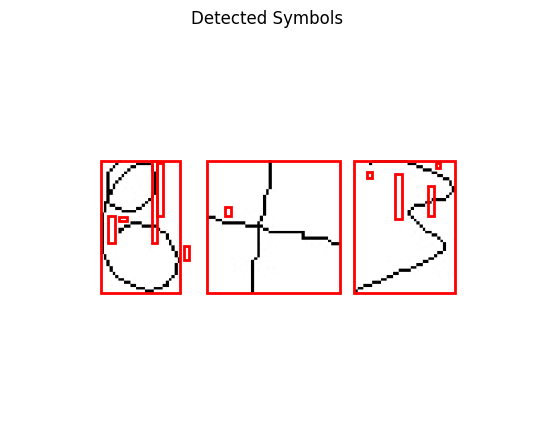

Equation: 8341=8+634238
Answer: Error evaluating equation


In [77]:
def predict_single_equation(model, img_path, class_names):
    """Predict and solve a single equation from an image"""
    # Load and binarize the image
    input_image = cv2.imread(img_path, 0)
    inverted_binary_img = binarize(input_image)
    
    # Detect contours and sort left-to-right
    bounding_boxes = detect_contours(img_path)
    bounding_boxes = sorted(bounding_boxes, key=lambda x: x[0])  # Sort symbols left-to-right
    
    # Predict symbols and reconstruct the equation string
    eqn_list = []
    
    # Show original image with boxes
    plt.figure(figsize=(10, 5))
    plt.imshow(input_image, cmap='gray')
    for (x, y, w, h) in bounding_boxes:
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        plt.gca().add_patch(rect)
    plt.title('Detected Symbols')
    plt.axis('off')
    plt.show()
    
    # Process each symbol
    for (x, y, w, h) in bounding_boxes:
        # Resize and pad each symbol for the model
        img = resize_pad(inverted_binary_img[y:y+h, x:x+w], (45, 45), 0)
        
        # Predict the symbol class
        pred_class = class_names[np.argmax(model.predict(tf.expand_dims(tf.expand_dims(img, 0), -1), verbose=0))]
        
        # Map "times" to "*" for evaluation
        if pred_class == "times":
            pred_class = "*"
        eqn_list.append(pred_class)
    
    # Join symbols to form the full equation
    predicted_eqn = ''.join(eqn_list)
    
    # Calculate the answer
    try:
        answer = eval(predicted_eqn)
    except Exception as e:
        answer = "Error evaluating equation"
    
    # Print results
    print(f"Equation: {predicted_eqn}")
    print(f"Answer: {answer}")
    
    return predicted_eqn, answer

# Use it like this:
img_path = "test_equation_images/2numbers_test_020.png"  # Replace with your image path
equation, answer = predict_single_equation(model, img_path, class_names)


In [52]:
def calculate_iou(box1, box2):
    """Calculate Intersection over Union for two boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is no intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

def evaluate_detection(detected_boxes, ground_truth_boxes, iou_threshold=0.5):
    """Evaluate detection accuracy"""
    true_positives = 0
    false_positives = len(detected_boxes)
    false_negatives = len(ground_truth_boxes)
    
    for det_box in detected_boxes:
        for gt_box in ground_truth_boxes:
            if calculate_iou(det_box, gt_box) > iou_threshold:
                true_positives += 1
                false_positives -= 1
                false_negatives -= 1
                break
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    }

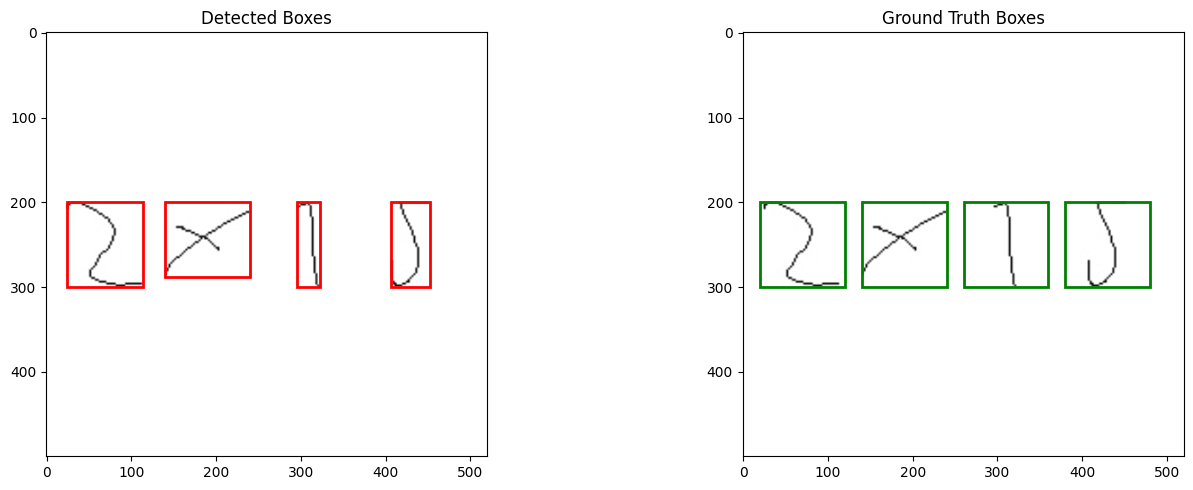

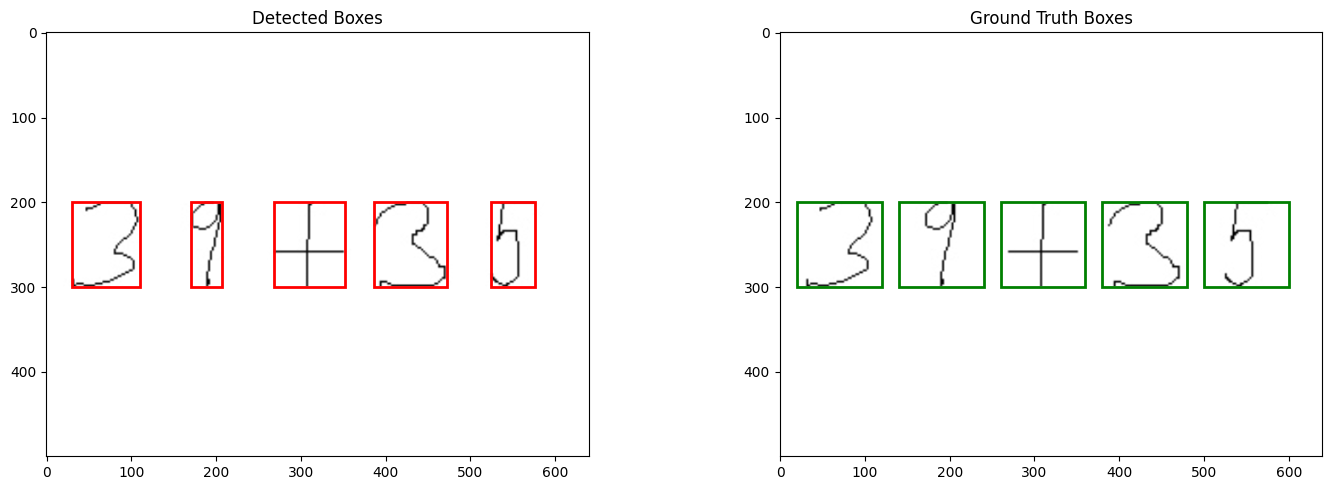

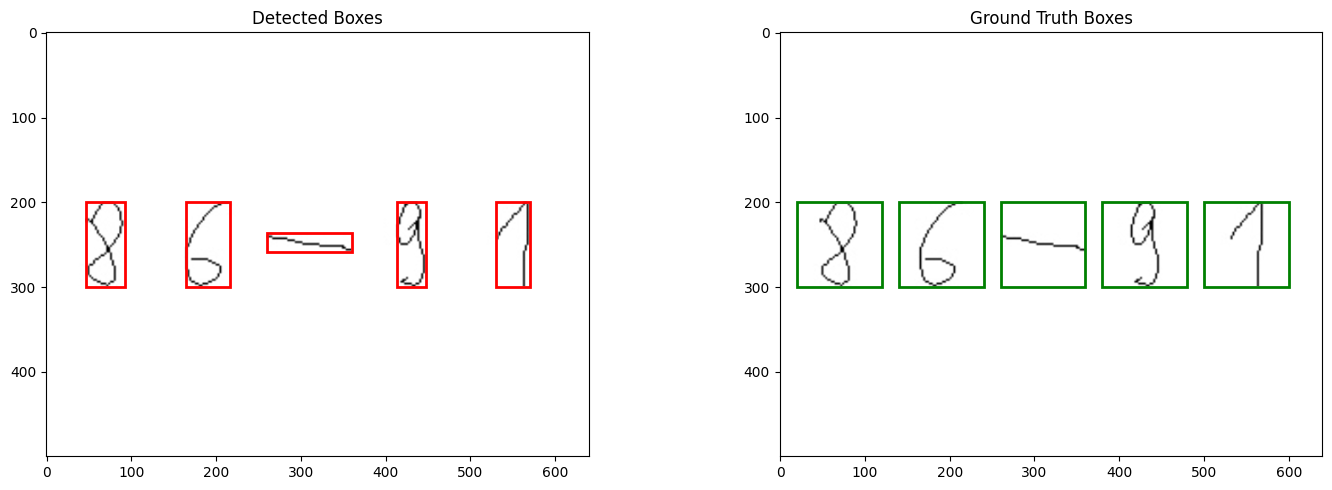

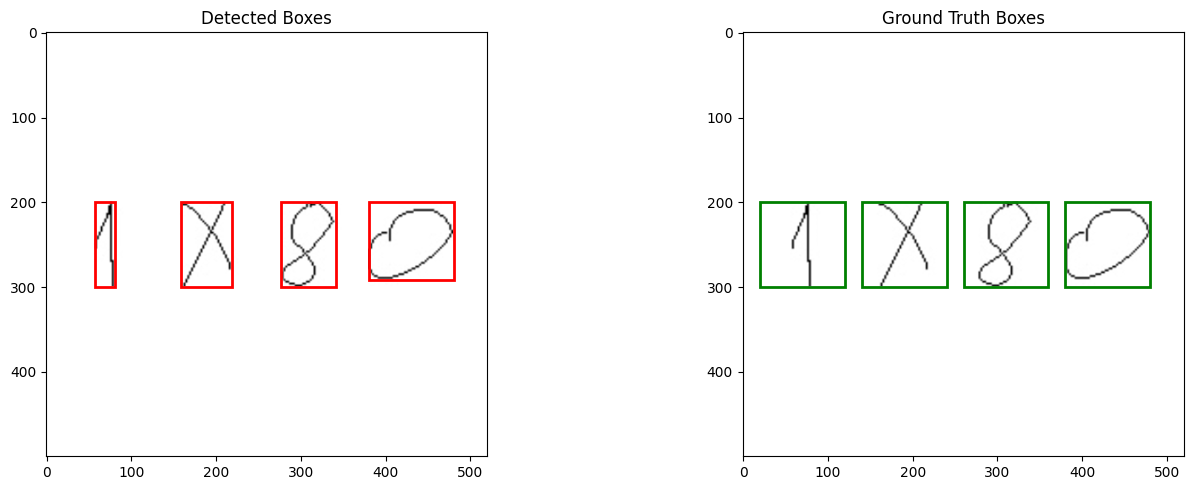

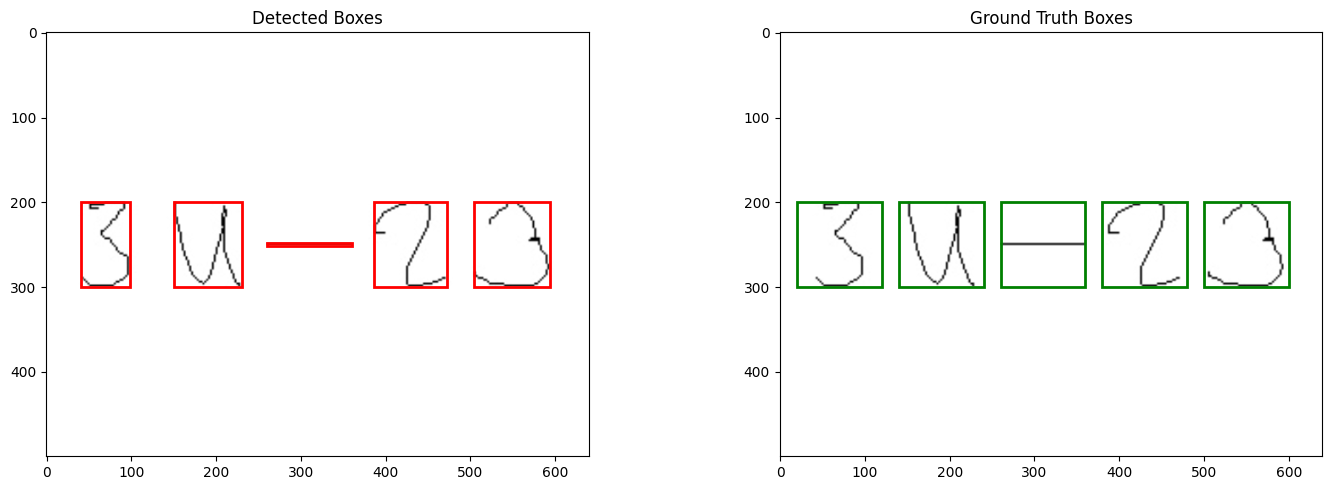

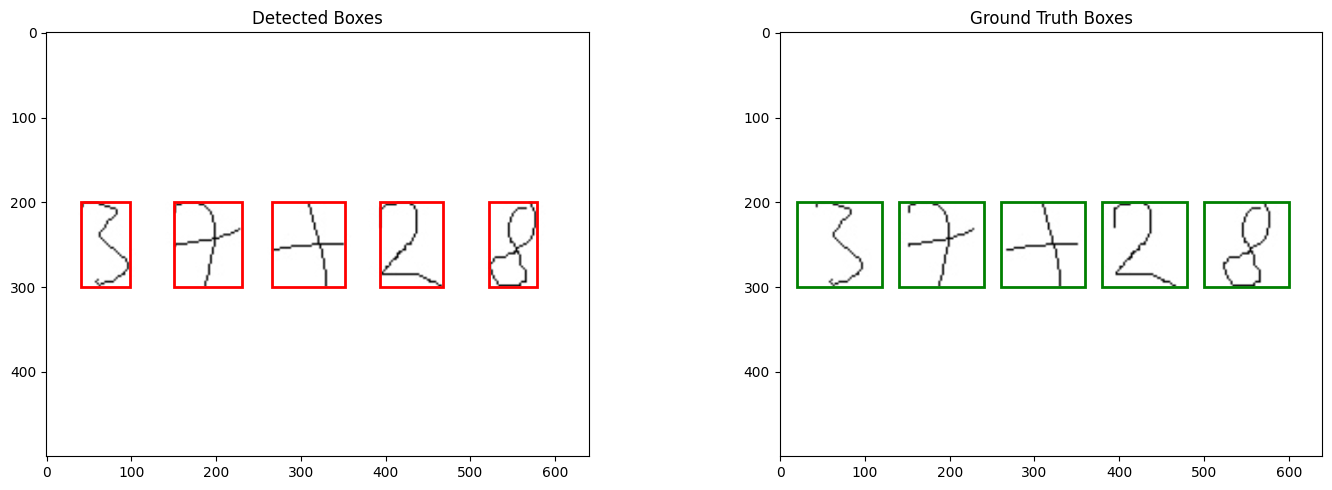

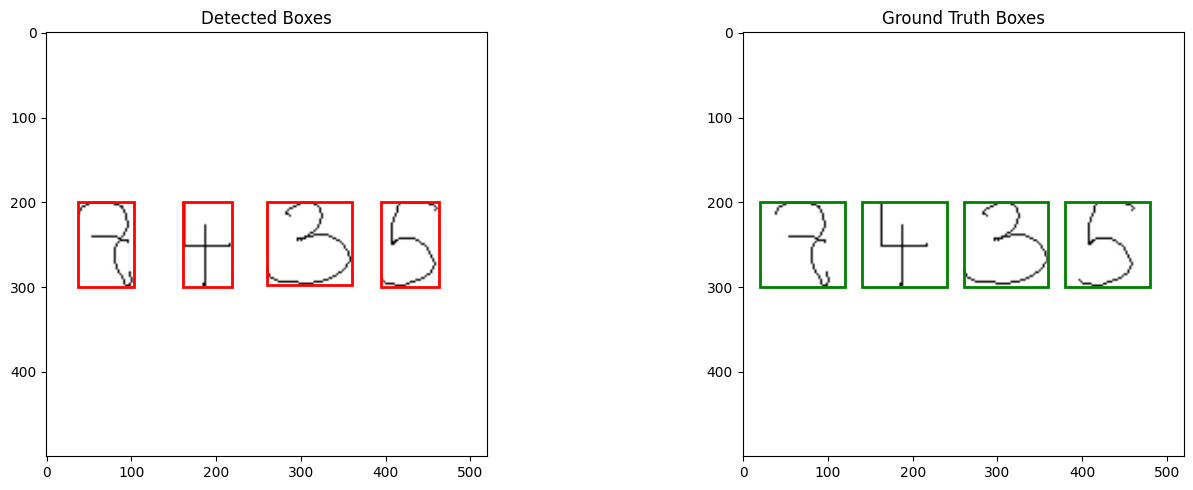

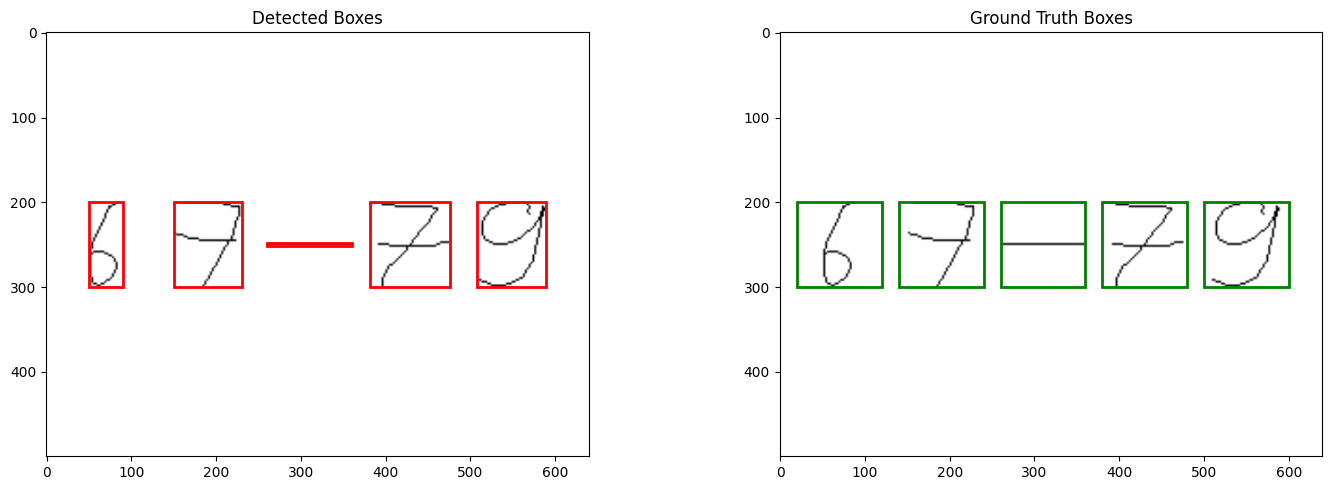

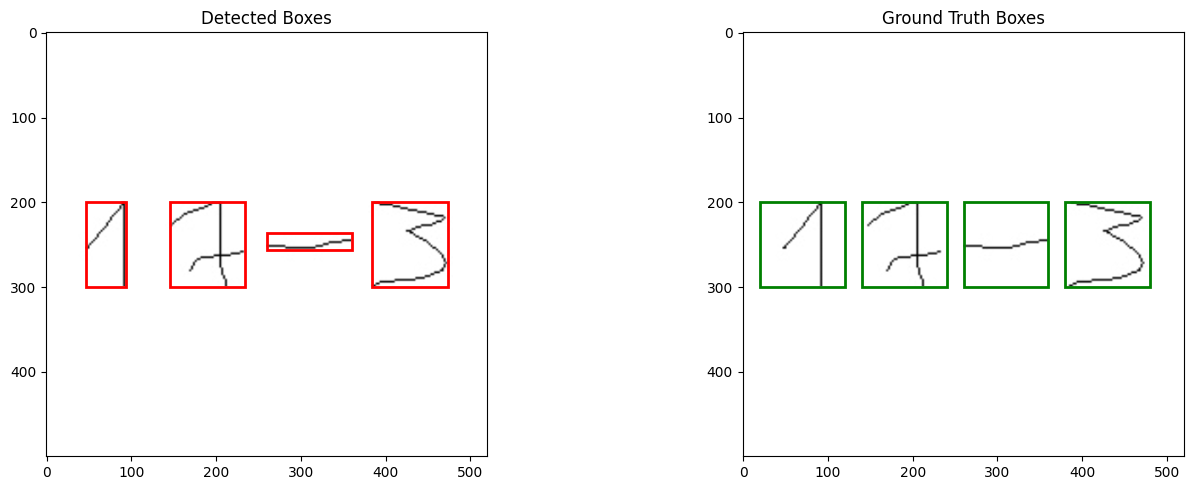

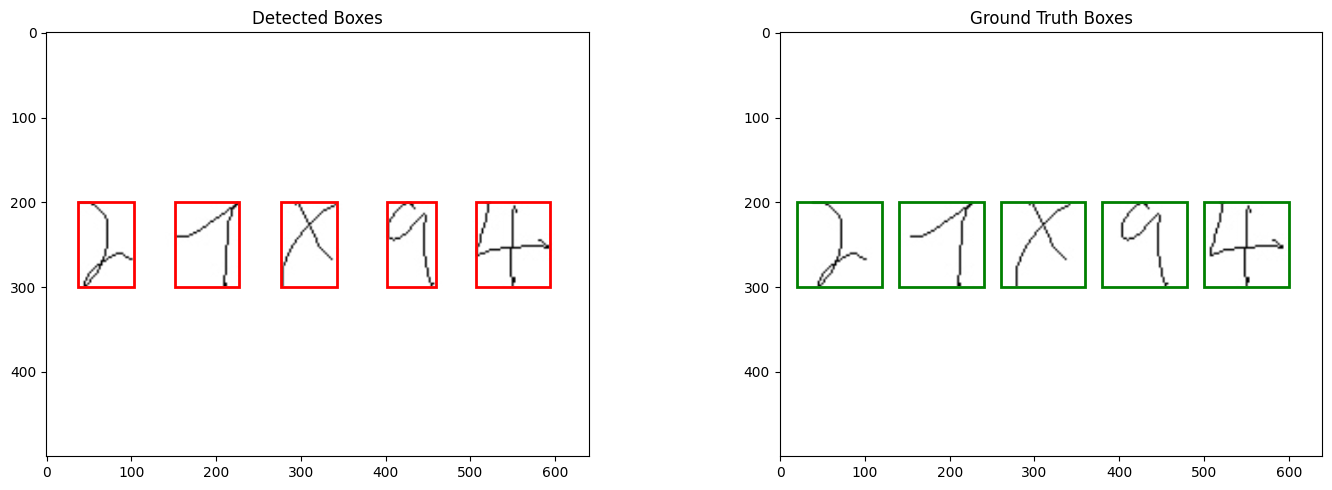

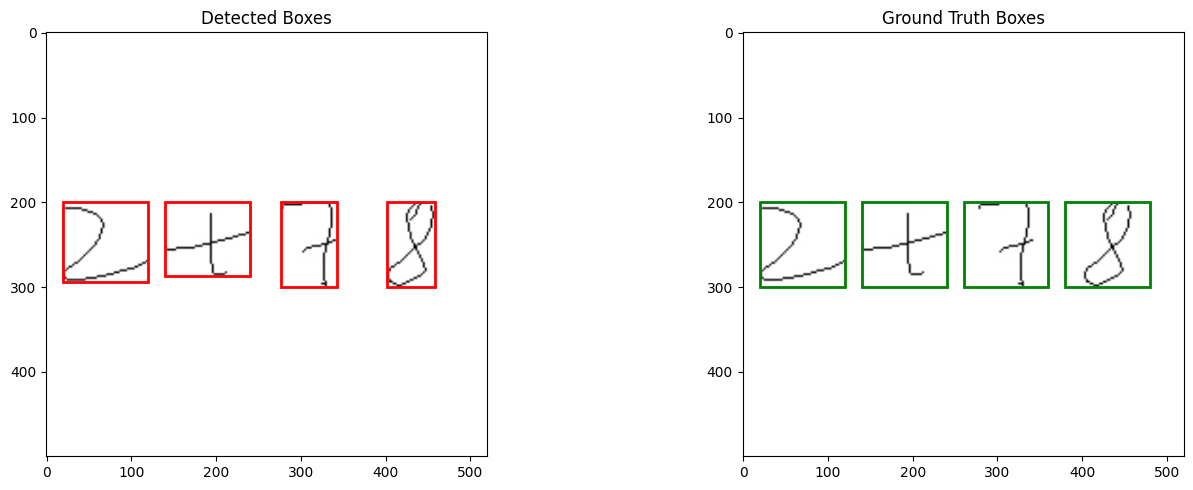

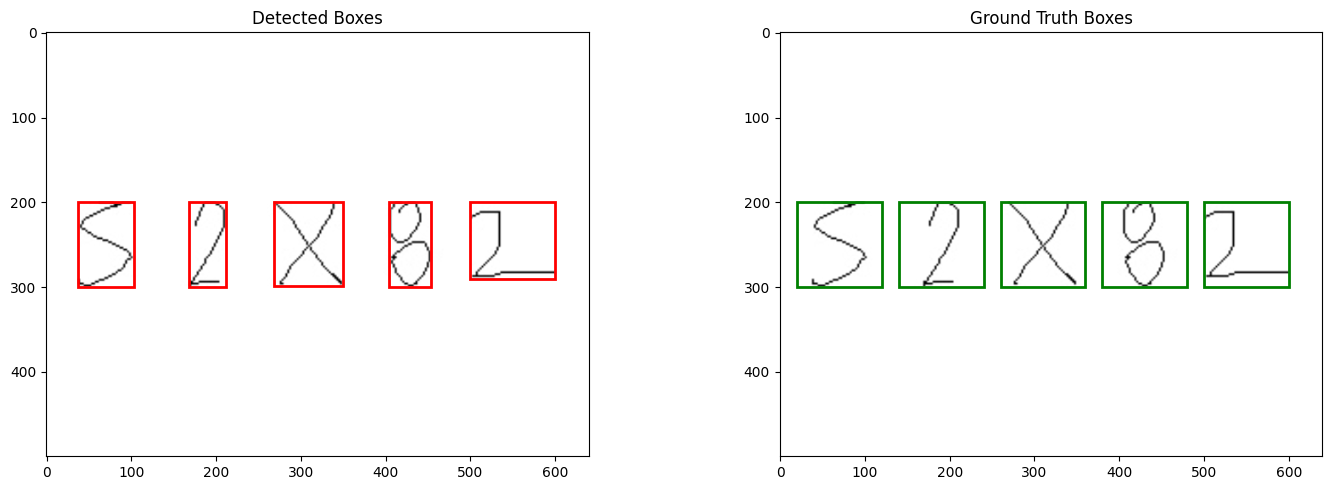

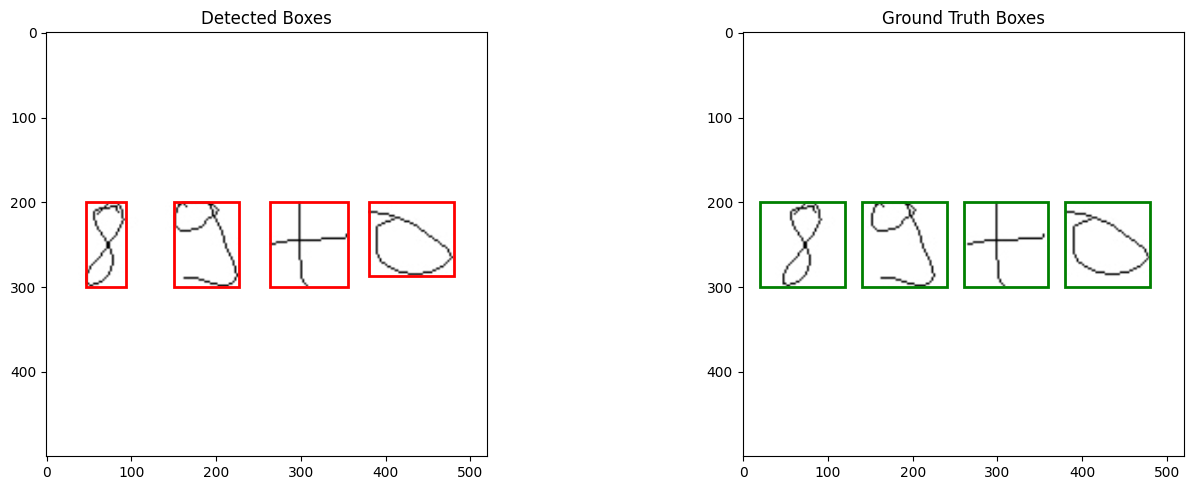

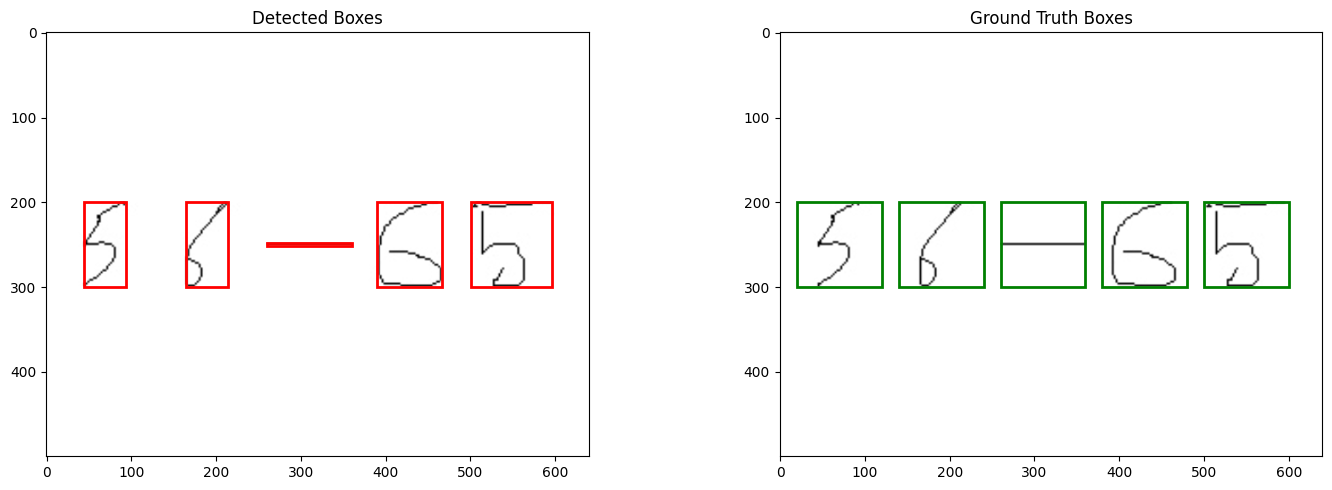

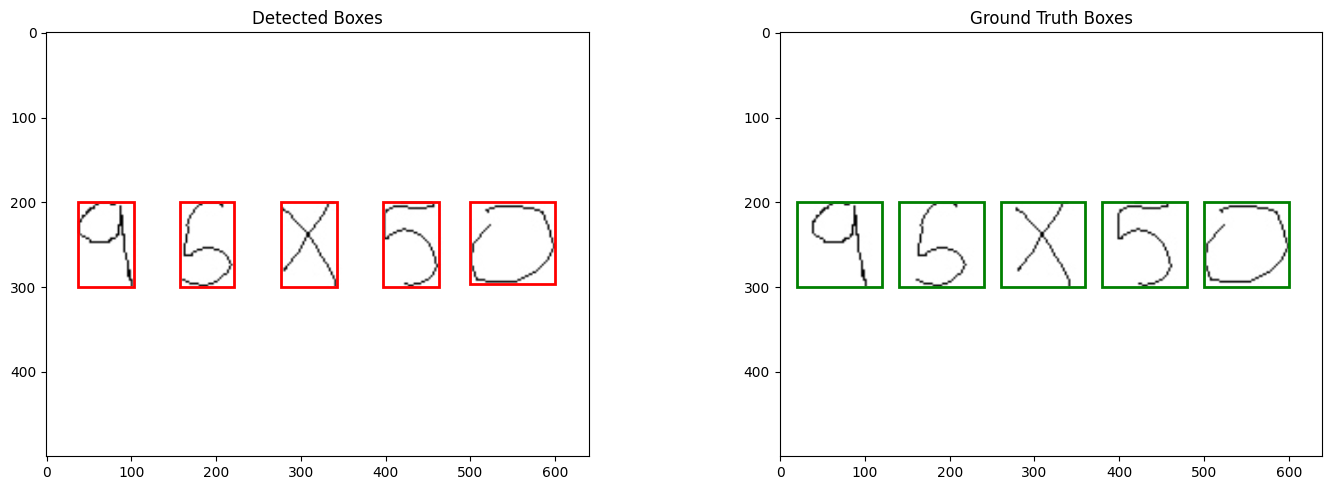

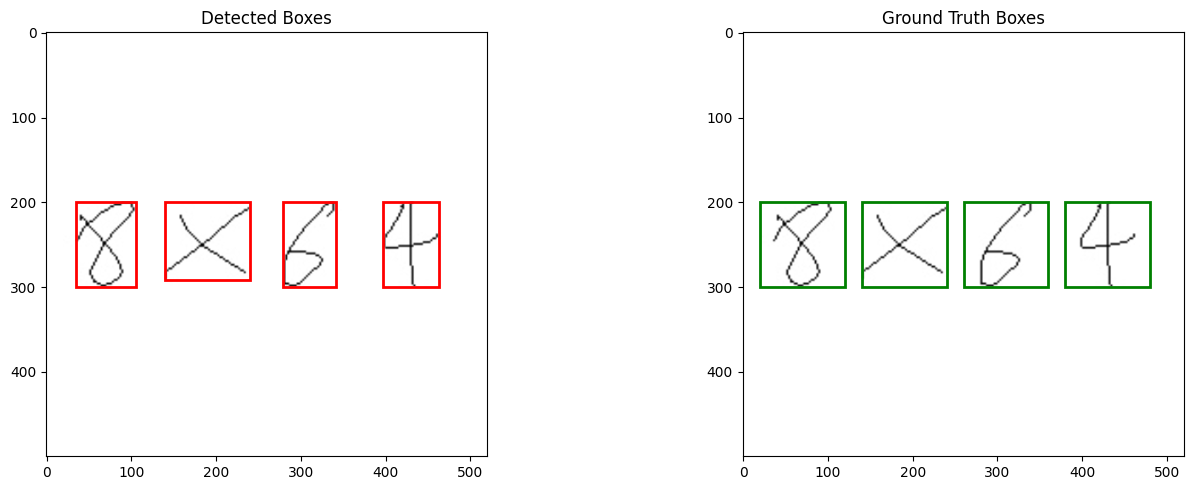

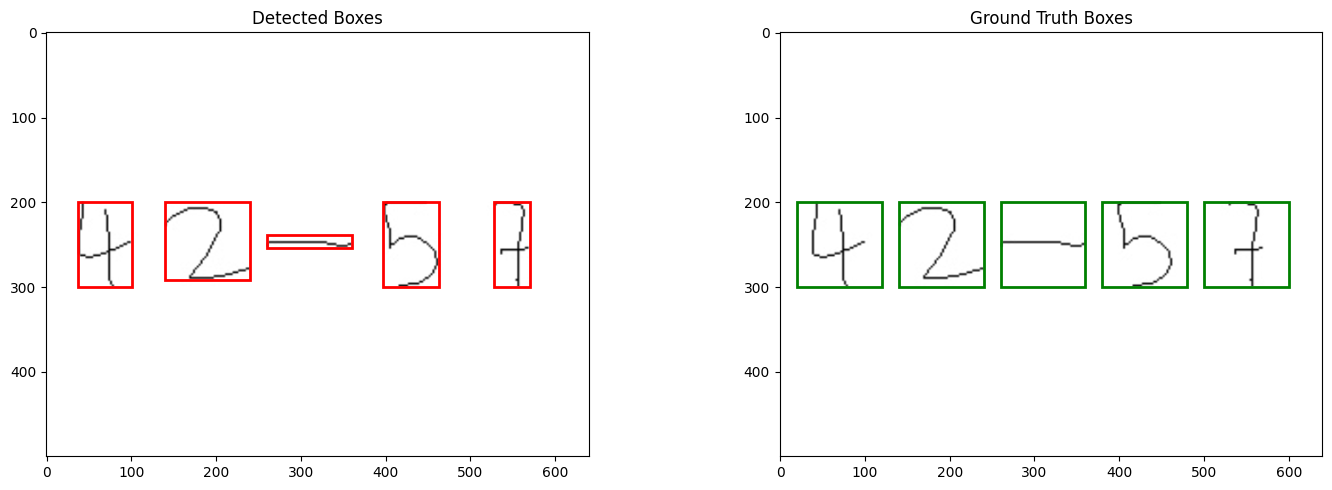

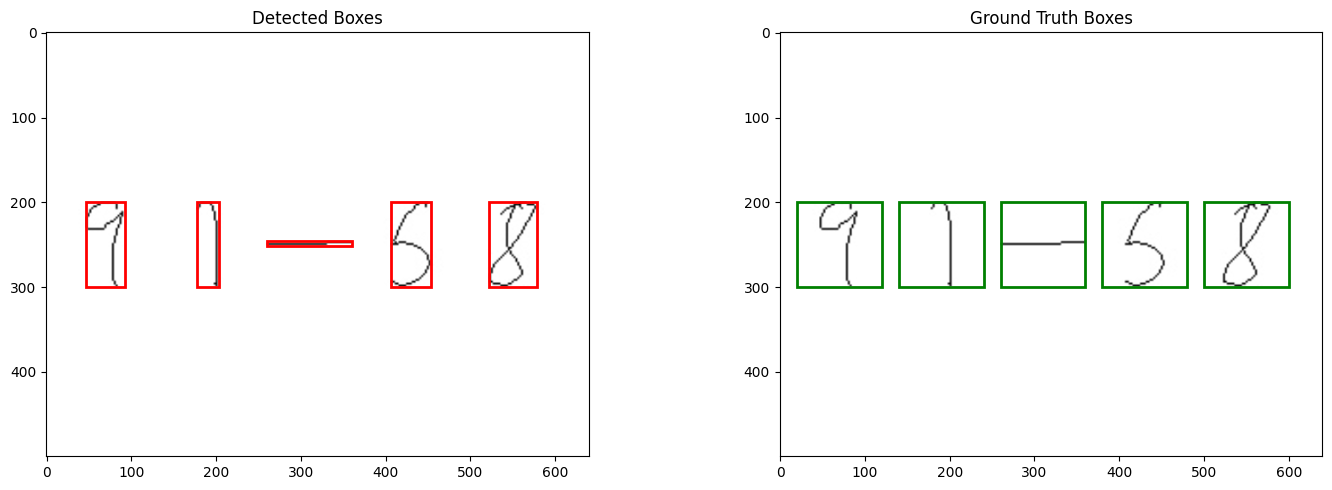

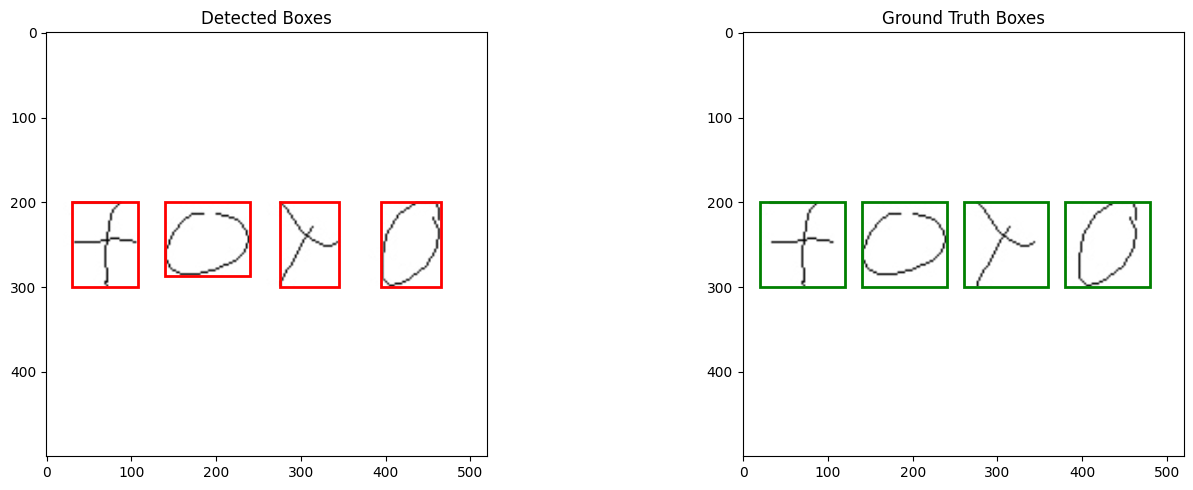

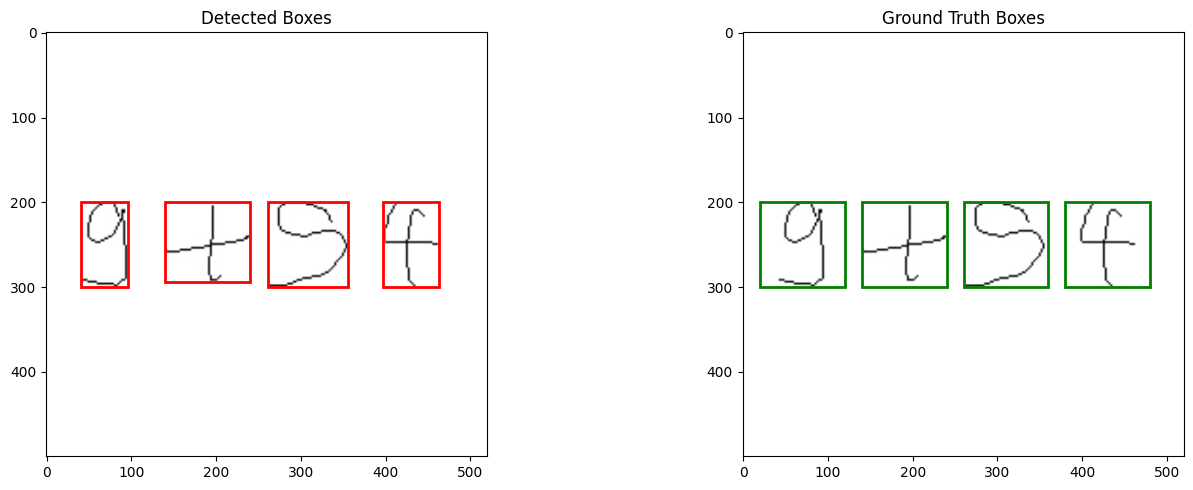

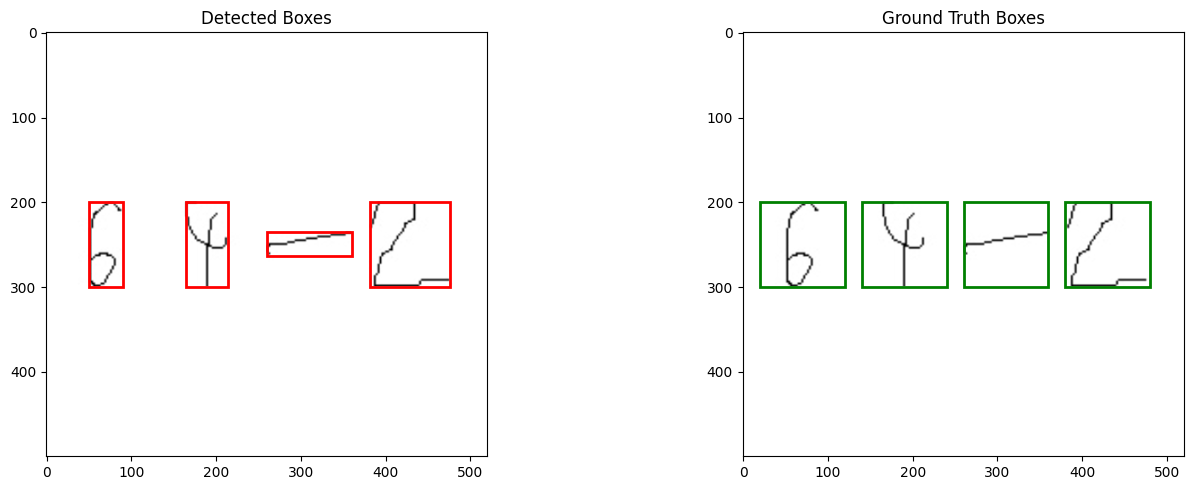

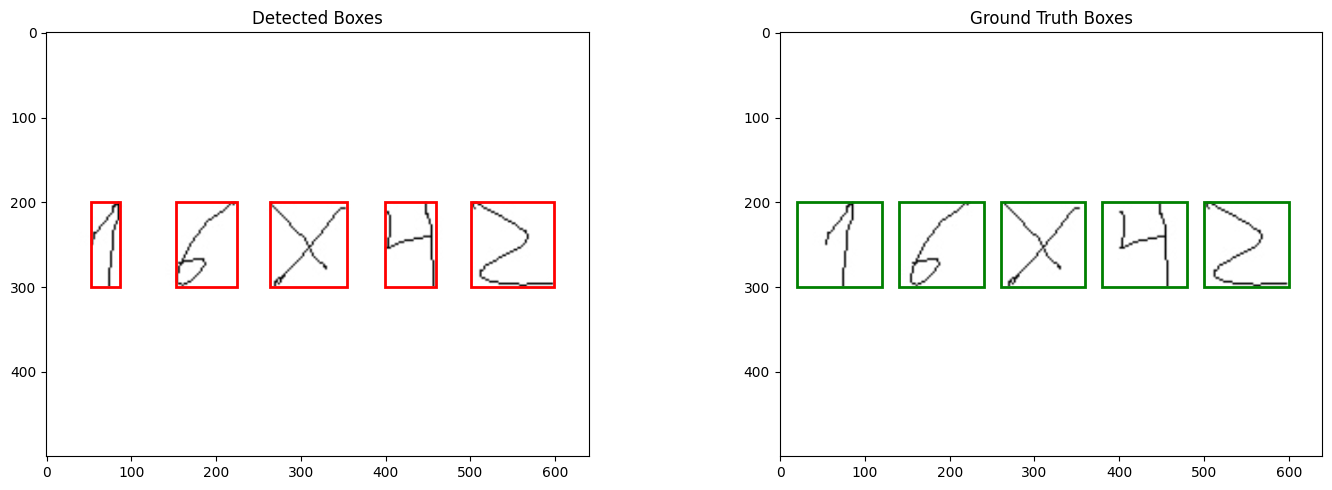

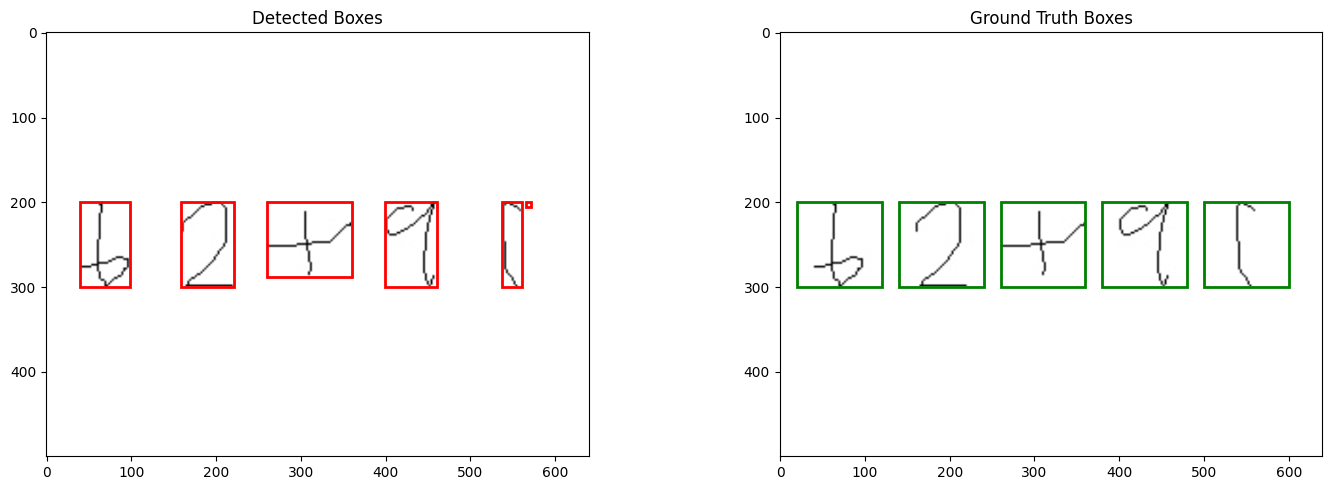

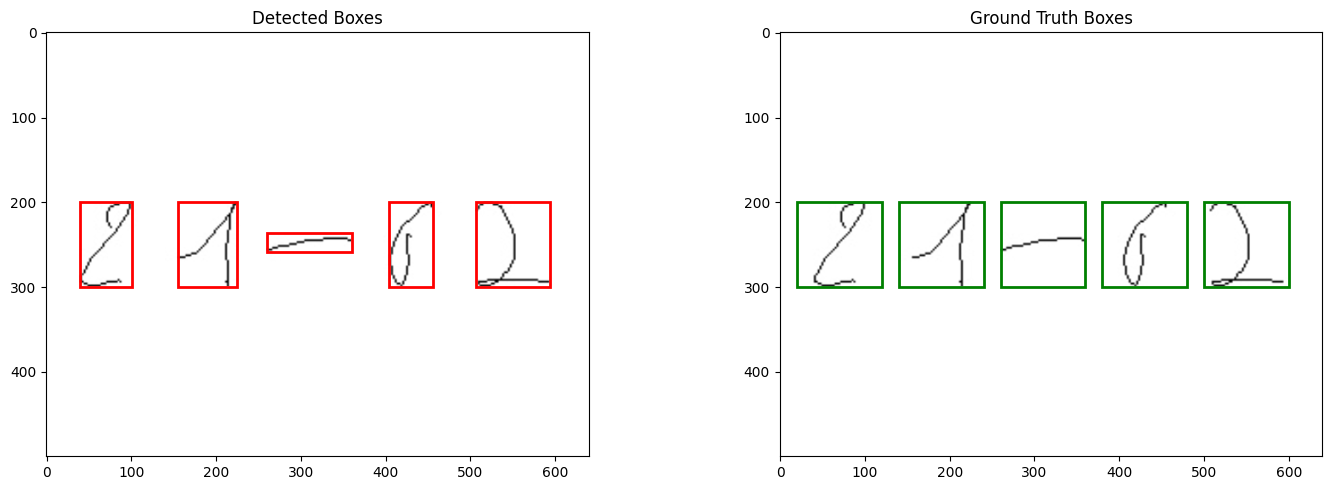

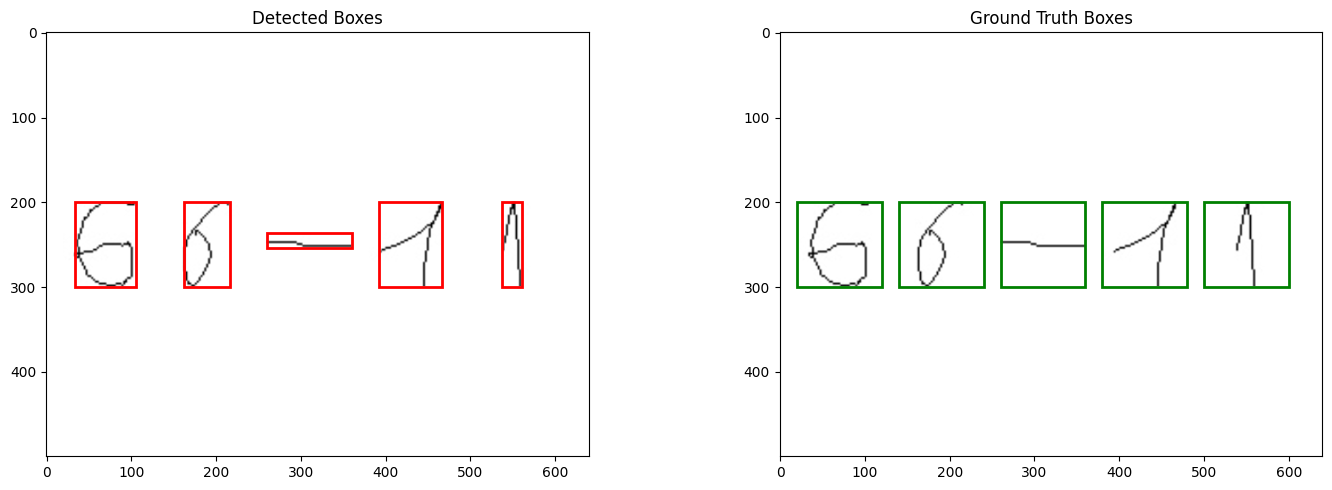

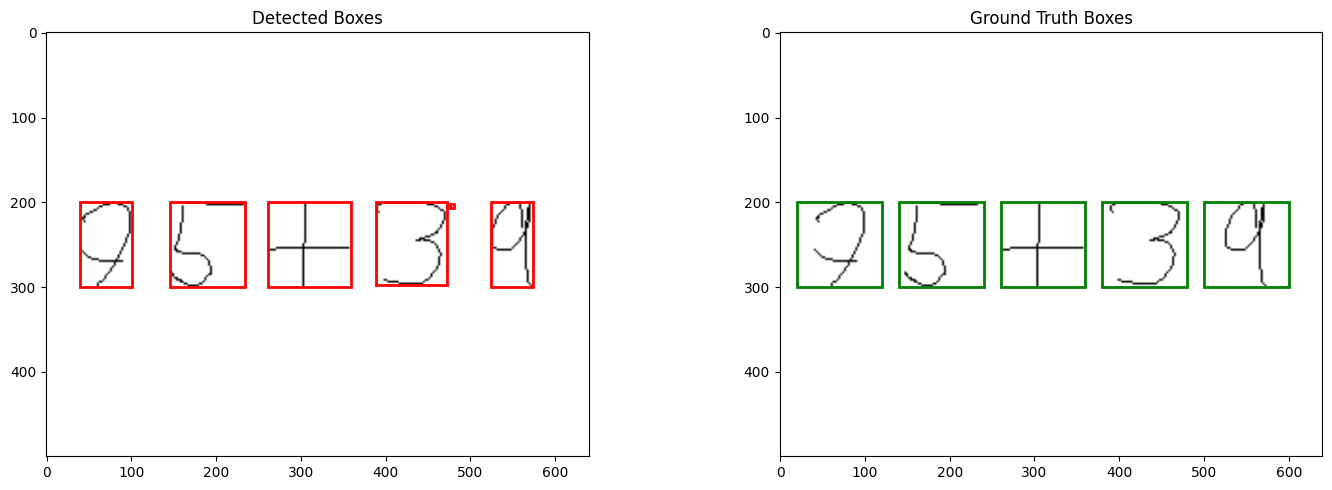

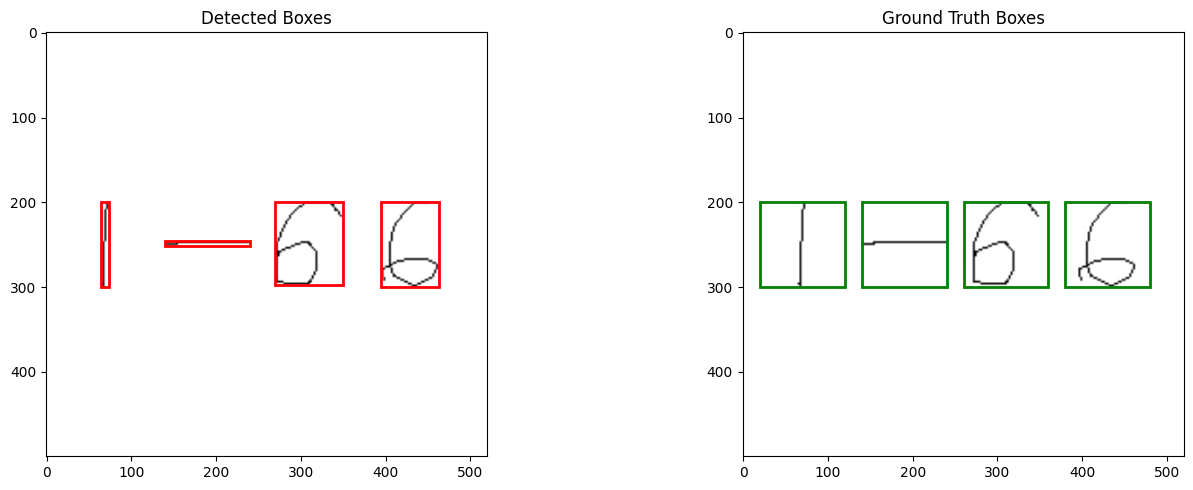

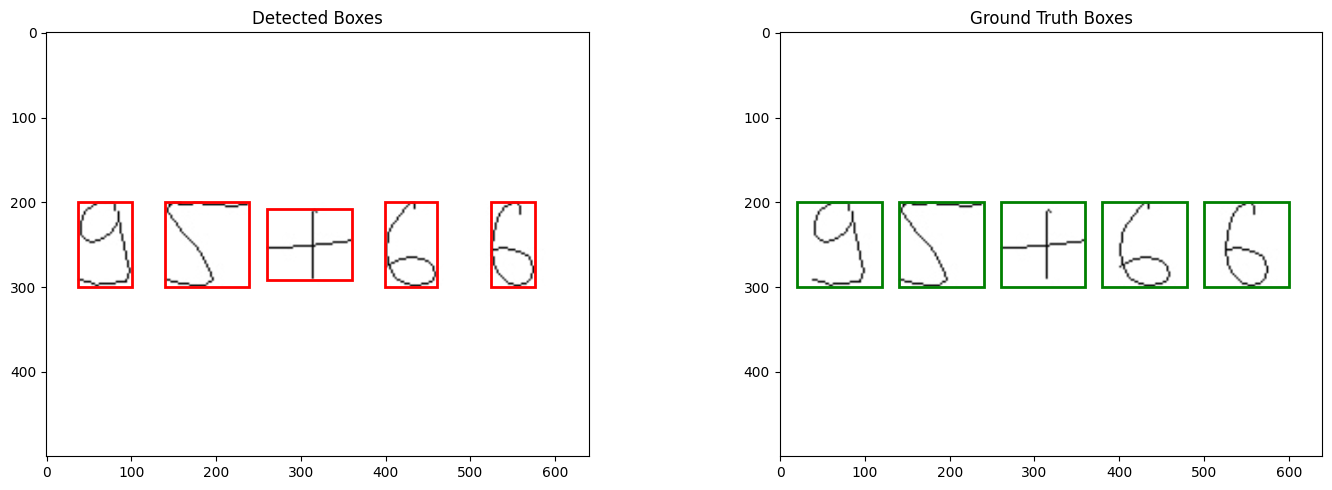

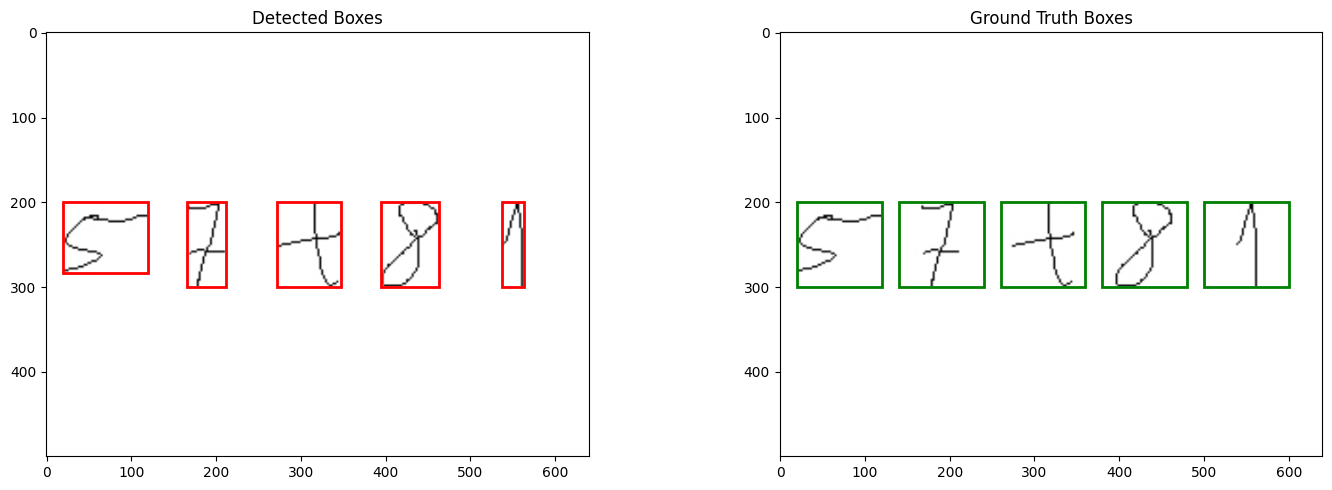

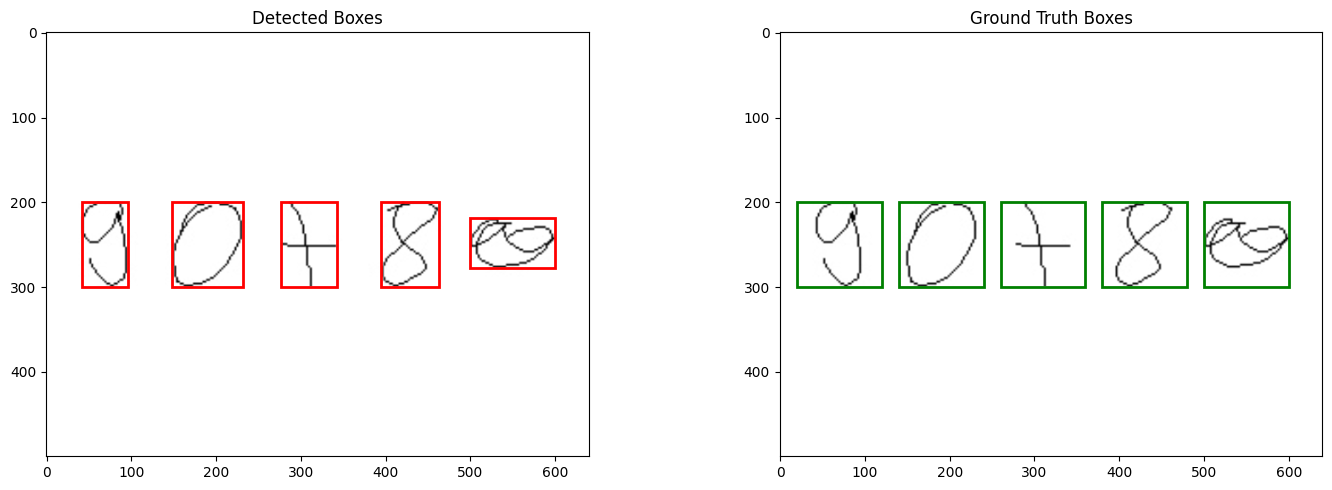

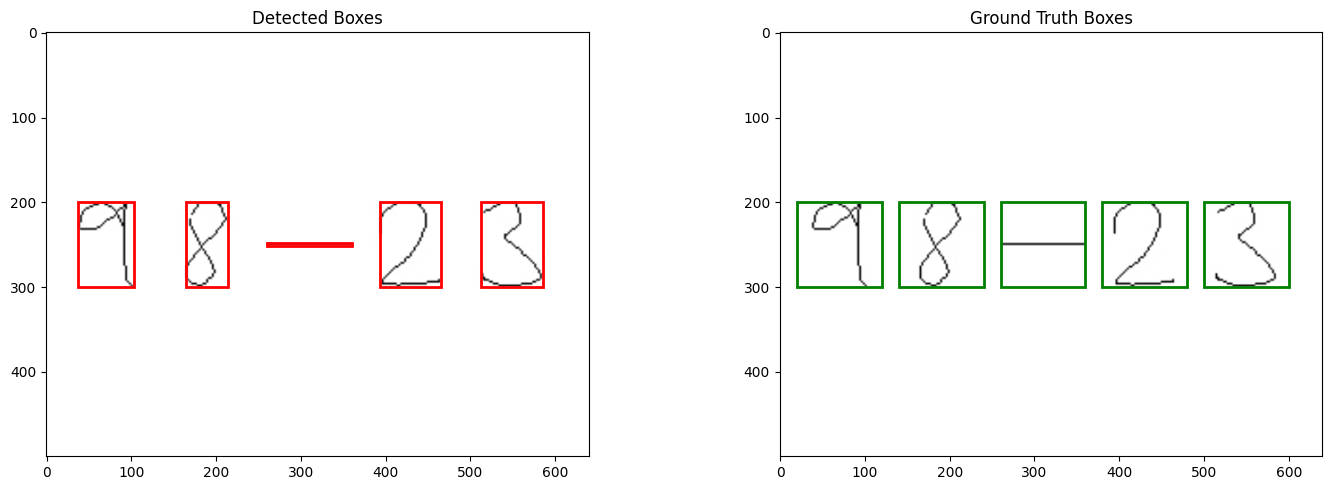

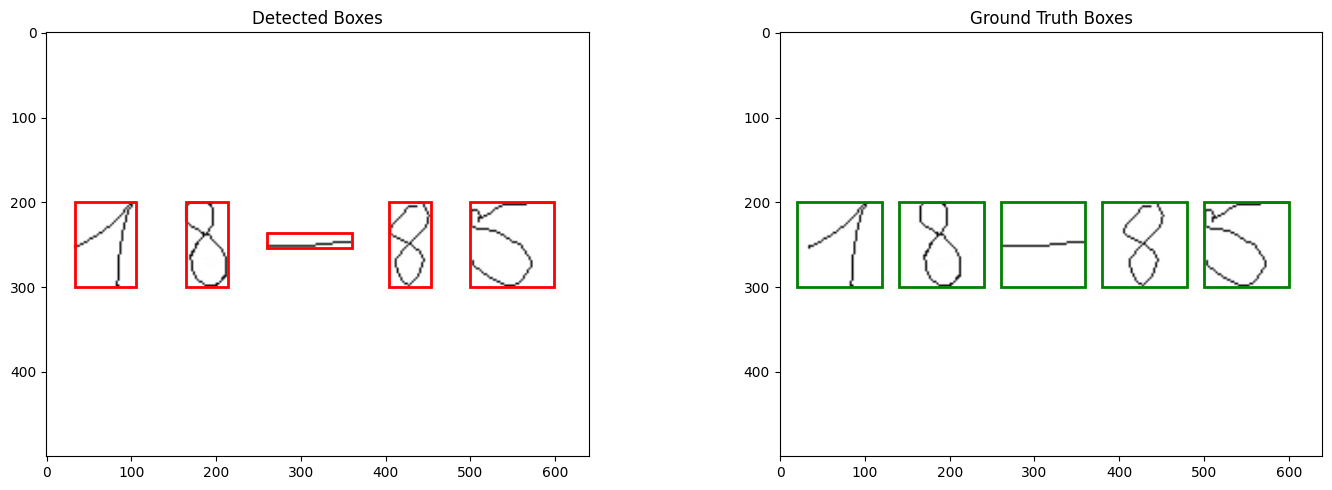

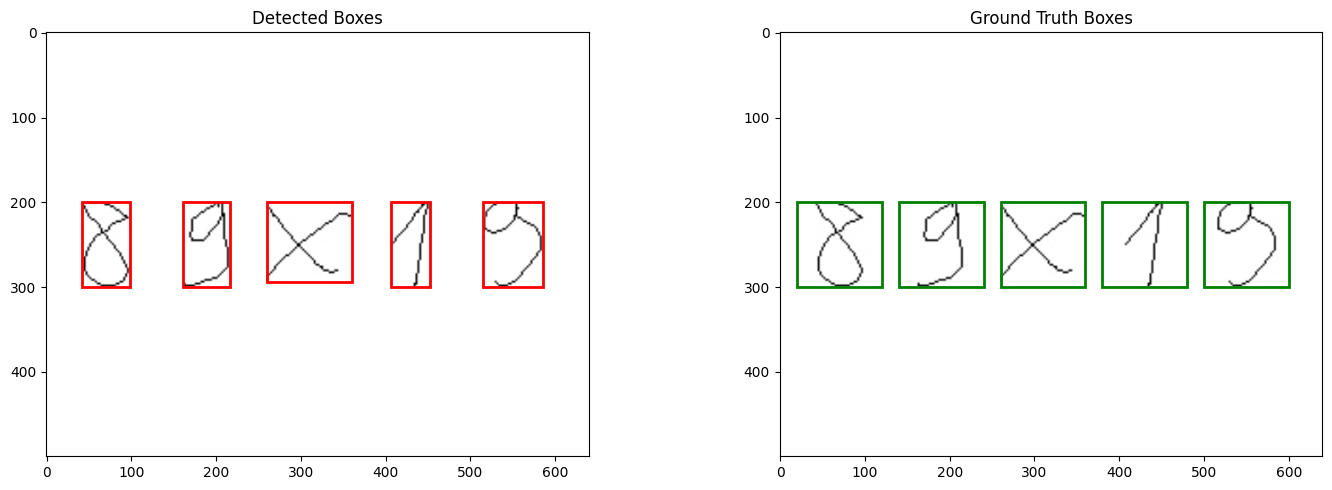

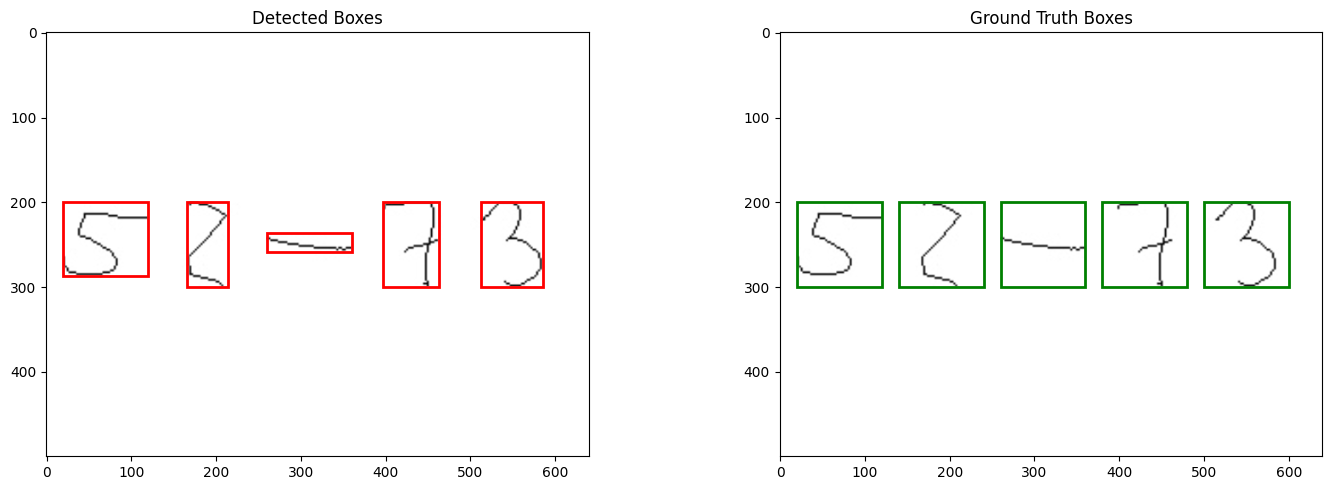

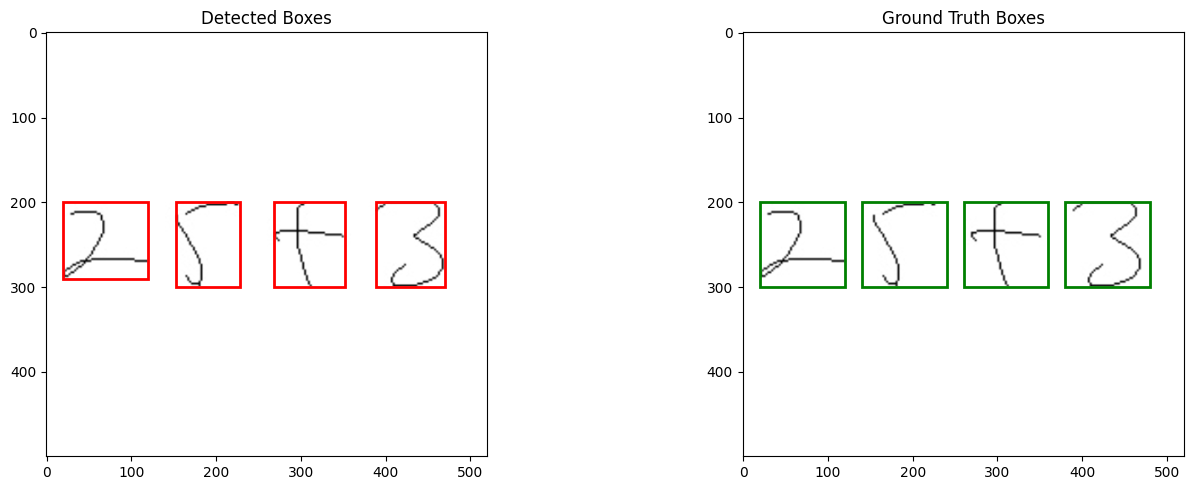

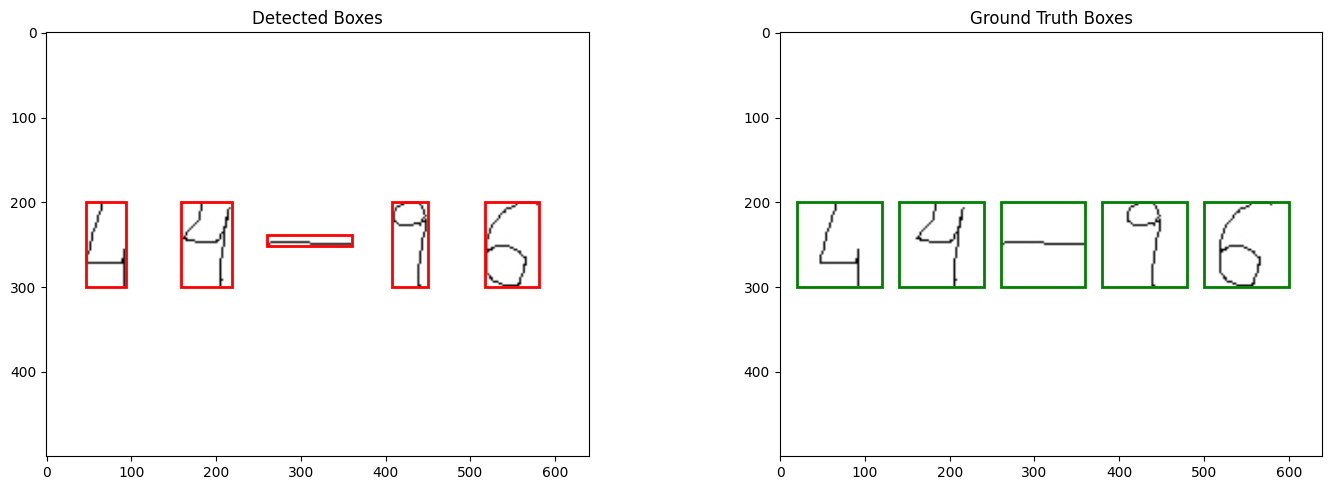

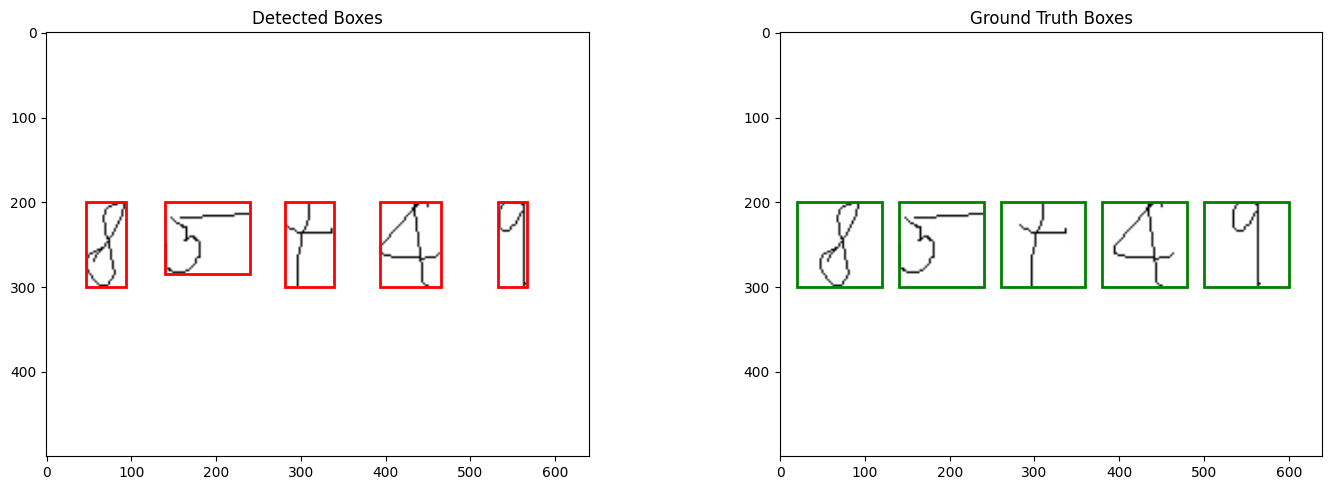

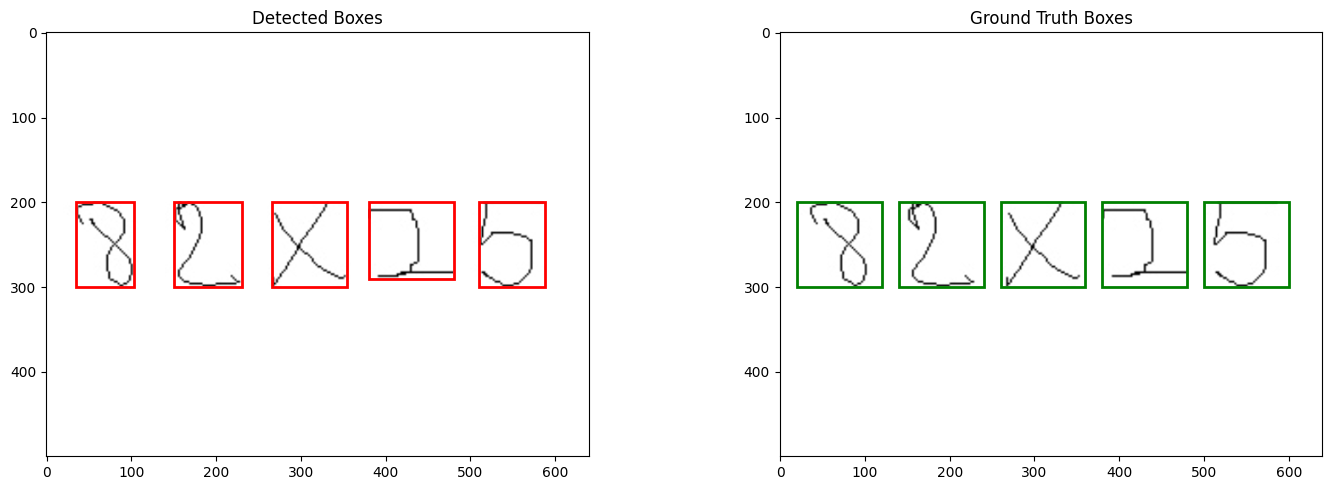

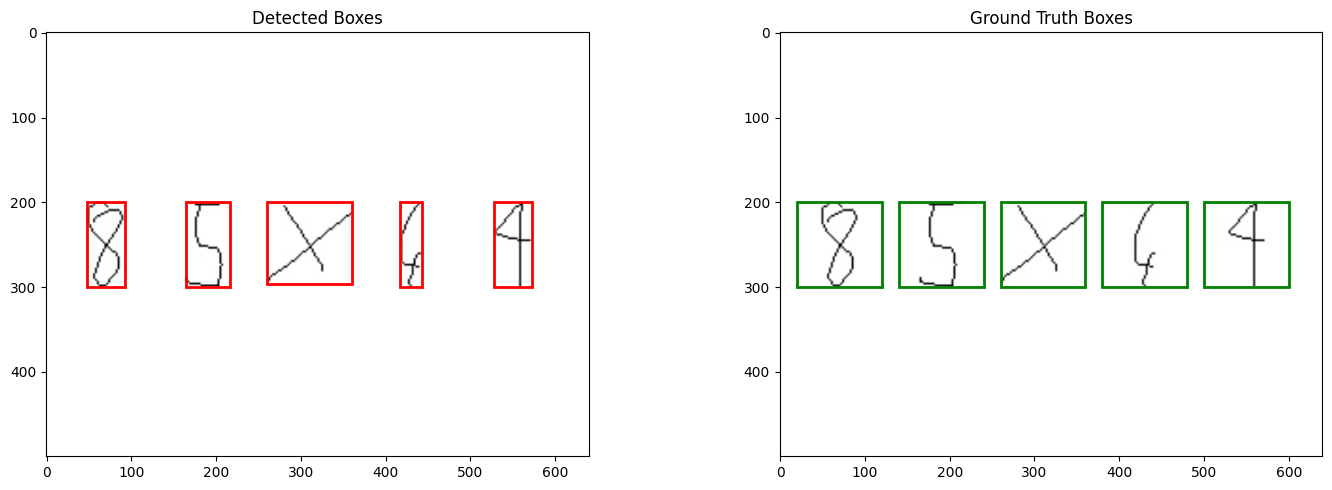

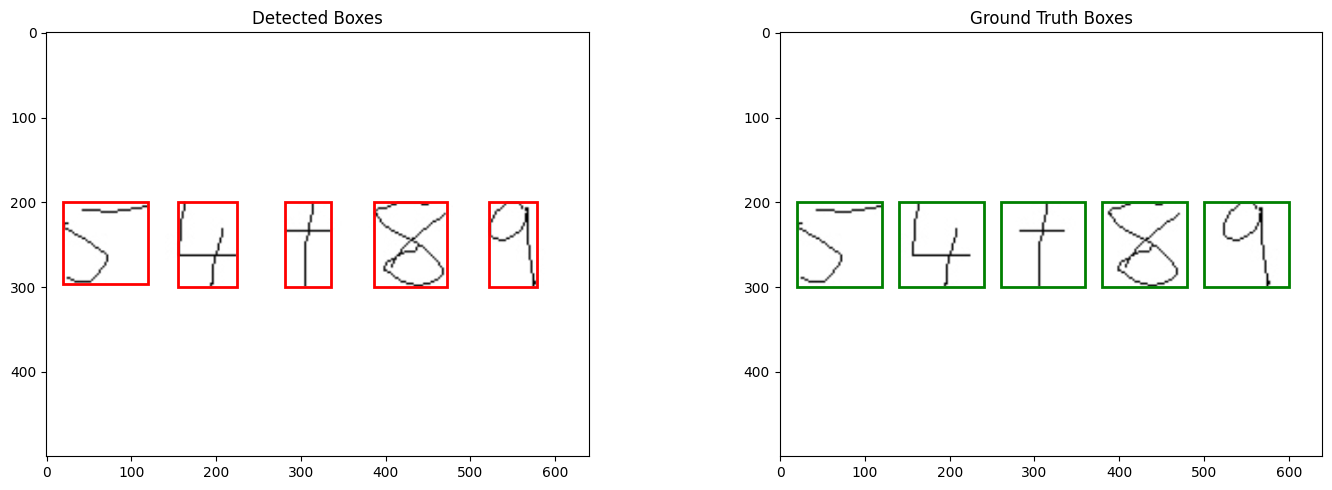

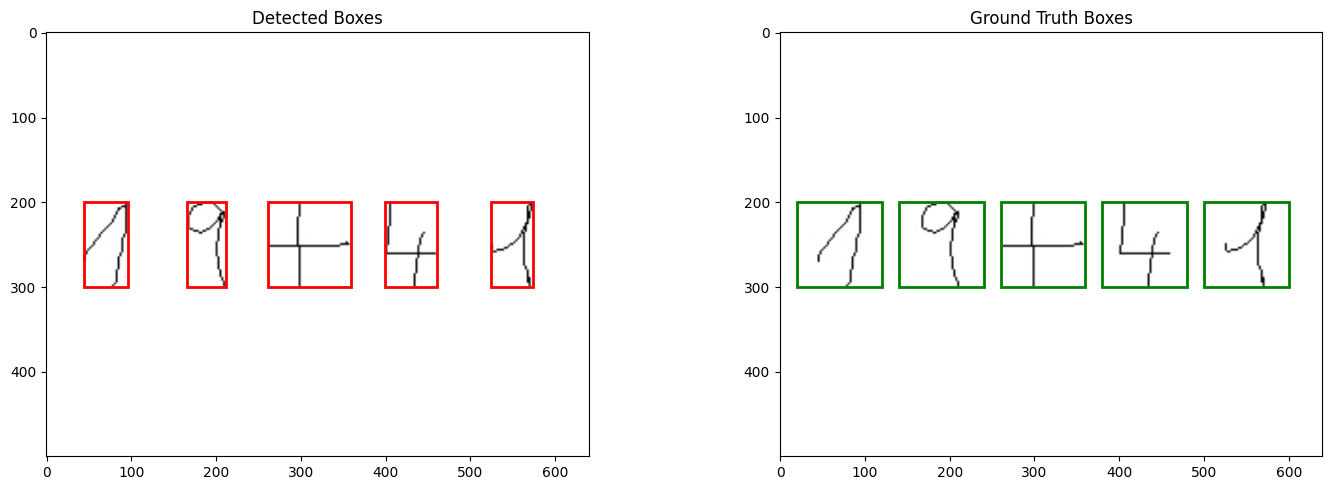

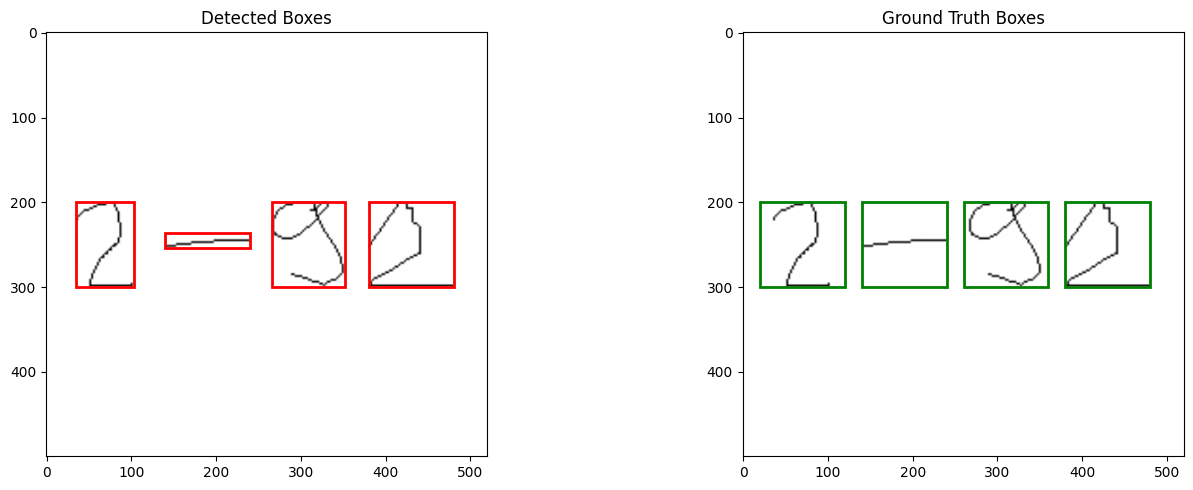

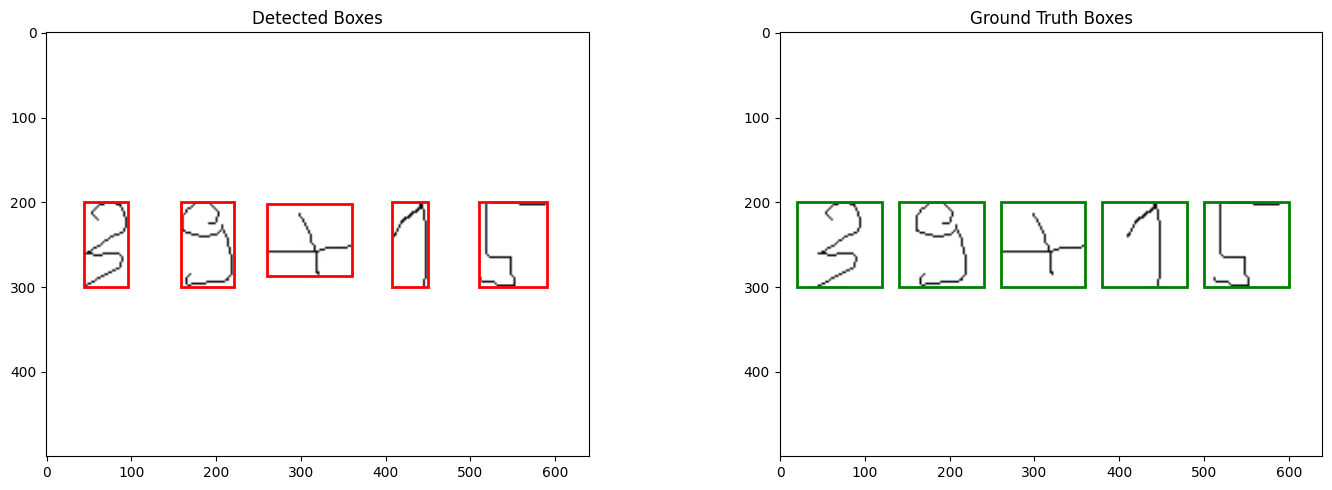

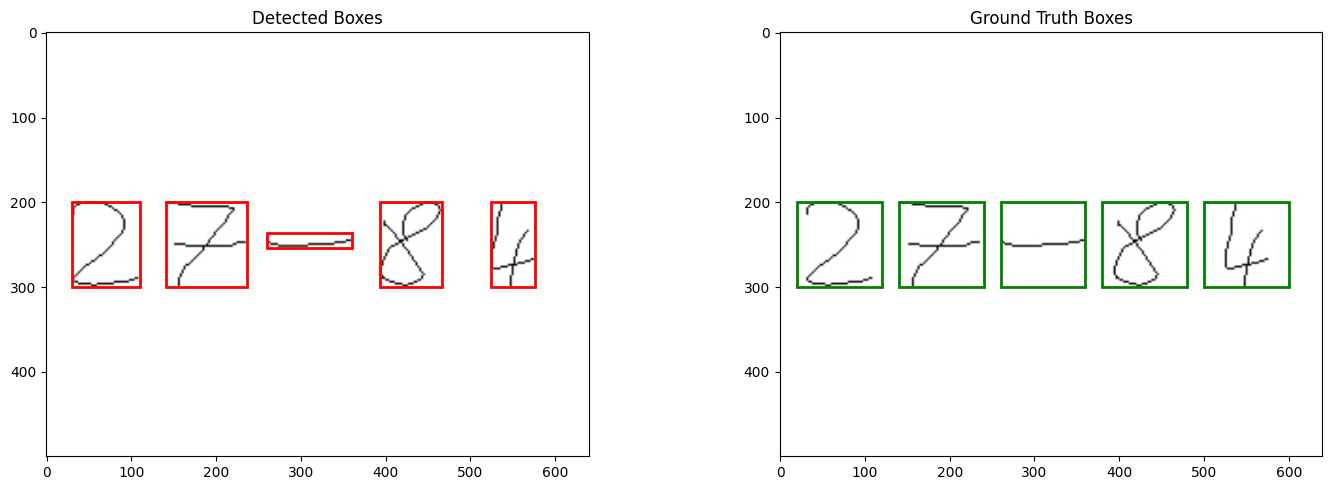

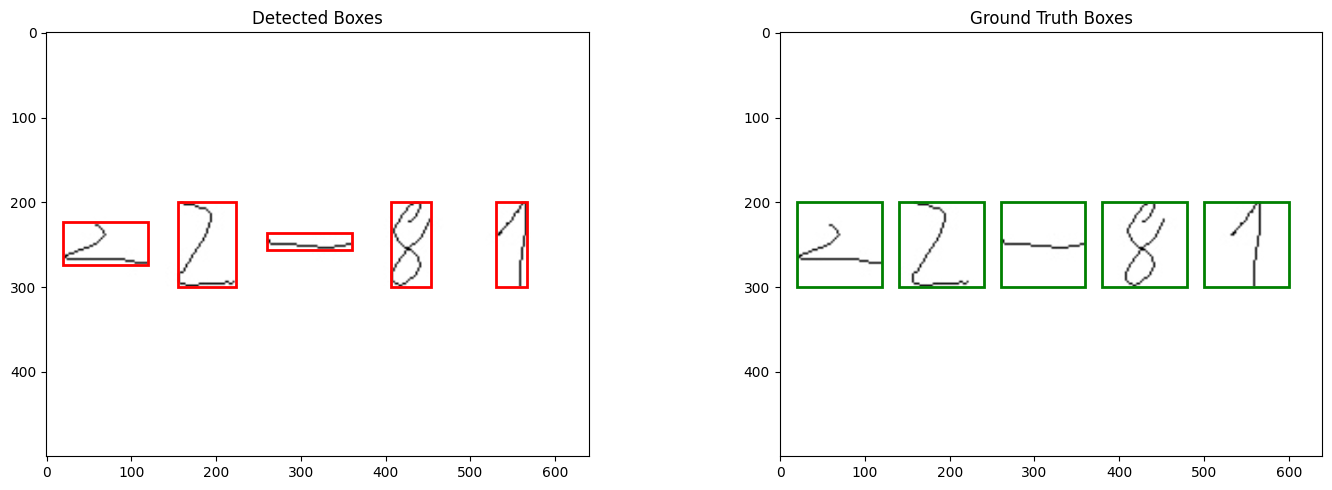

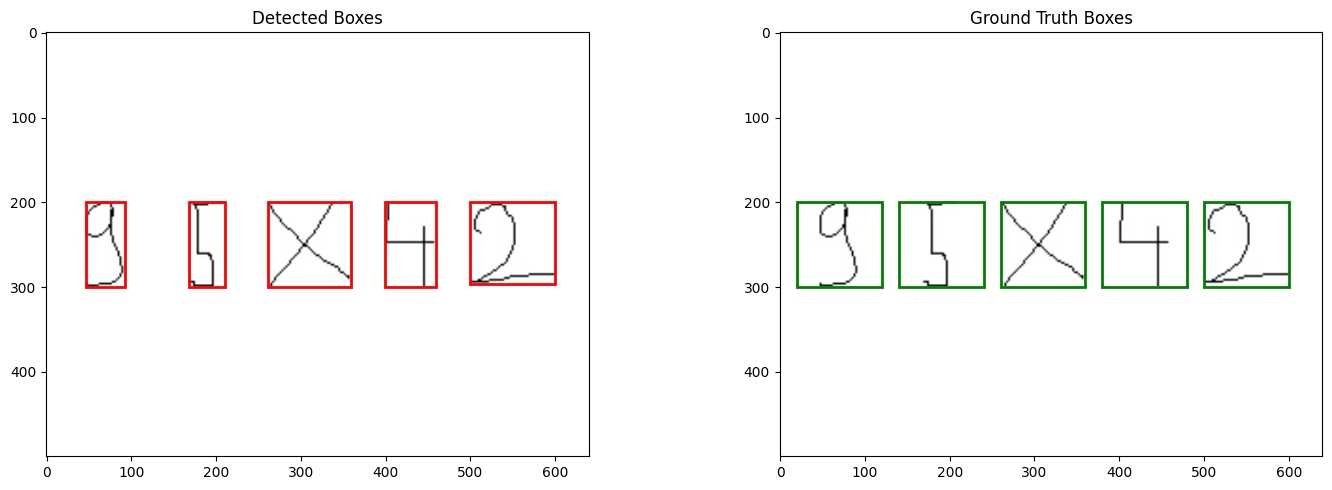

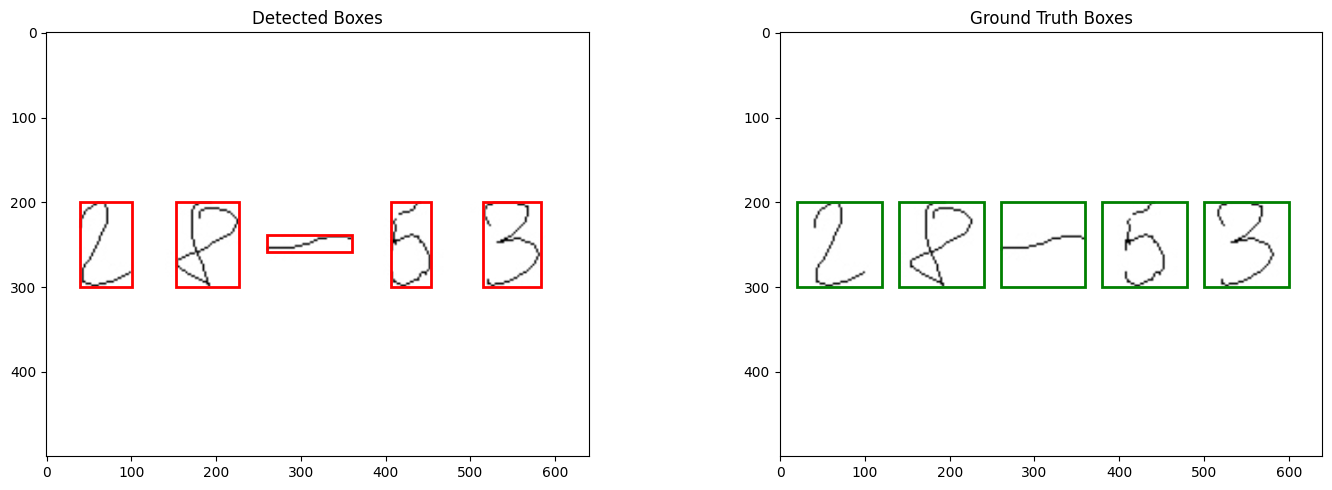

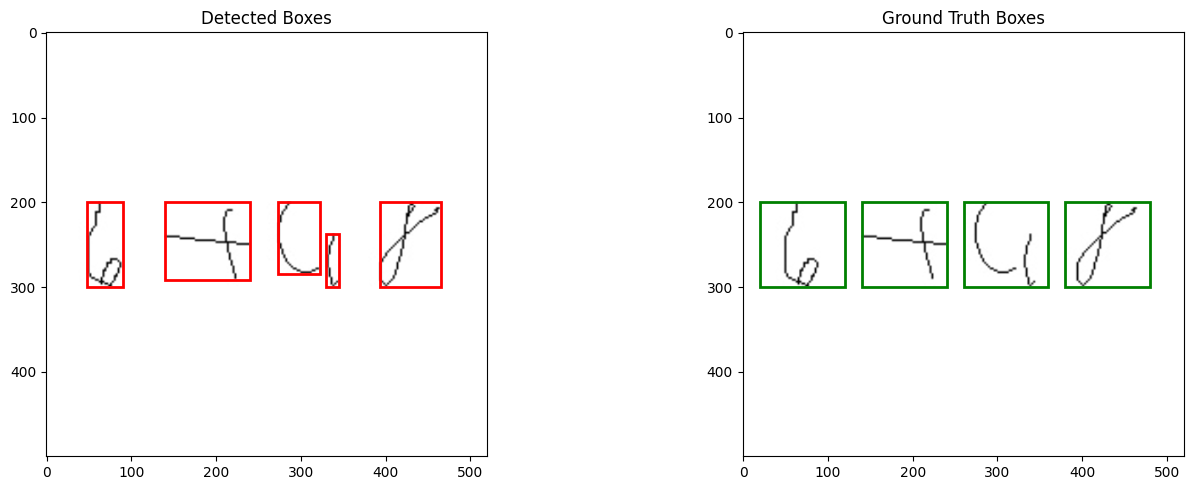

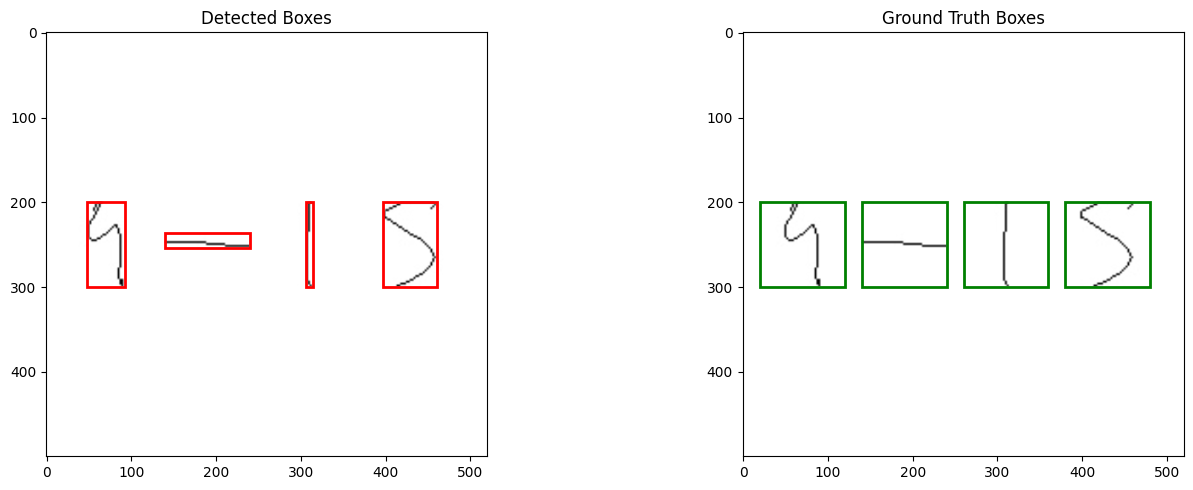

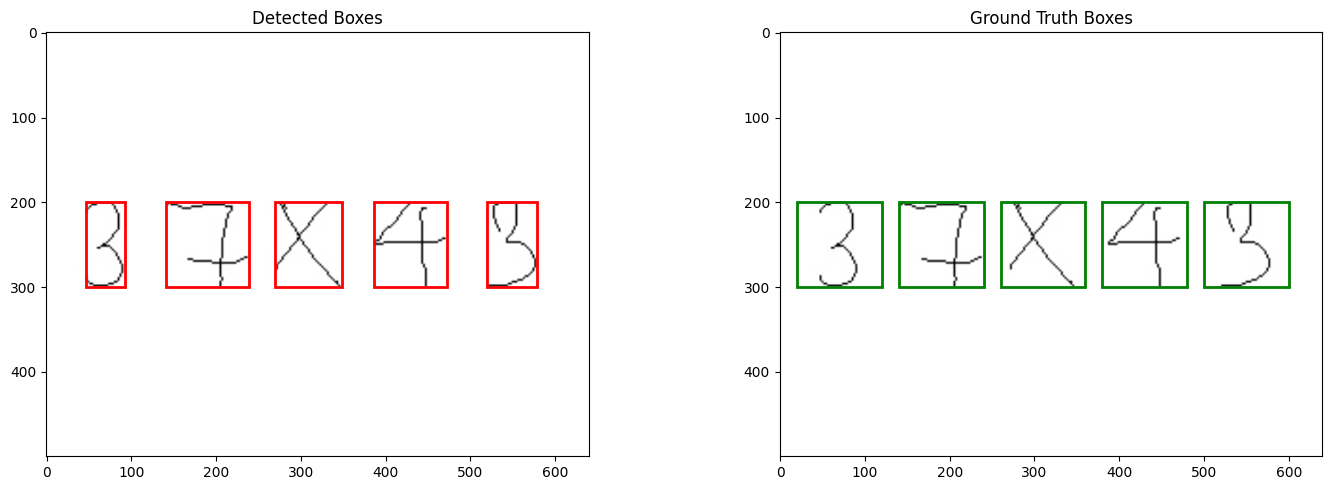

Average Detection Metrics: {'precision': 0.6876666666666665, 'recall': 0.695, 'f1_score': 0.690979797979798}


In [54]:
import json
def evaluate_equation_detection(image_path):
    # Get detected boxes
    detected_boxes = detect_contours(image_path)
    
    # Load ground truth
    gt_path = image_path.replace('.png', '_gt.json')
    with open(gt_path, 'r') as f:
        ground_truth_data = json.load(f)
    
    # Evaluate detection
    metrics = evaluate_detection(detected_boxes, ground_truth_data['boxes'])
    
    # Visualize results
    img = cv2.imread(image_path, 0)
    plt.figure(figsize=(15, 5))
    
    # Plot with detected boxes
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    for box in detected_boxes:
        x, y, w, h = box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, color='red', linewidth=2))
    plt.title('Detected Boxes')
    
    # Plot with ground truth boxes
    plt.subplot(1, 2, 2)
    plt.imshow(img, cmap='gray')
    for box in ground_truth_data['boxes']:
        x, y, w, h = box
        plt.gca().add_patch(plt.Rectangle((x, y), w, h, 
                                        fill=False, color='green', linewidth=2))
    plt.title('Ground Truth Boxes')
    
    plt.tight_layout()
    plt.show()
    
    return metrics

output_folder = 'test_equation_images_withlabels'
# Evaluate all test images
all_metrics = []
for filename in os.listdir(output_folder):
    if filename.endswith('.png'):
        image_path = os.path.join(output_folder, filename)
        metrics = evaluate_equation_detection(image_path)
        all_metrics.append(metrics)

# Print average metrics
avg_metrics = {
    'precision': np.mean([m['precision'] for m in all_metrics]),
    'recall': np.mean([m['recall'] for m in all_metrics]),
    'f1_score': np.mean([m['f1_score'] for m in all_metrics])
}
print("Average Detection Metrics:", avg_metrics)

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json

def calculate_iou(box1, box2):
    """Calculate Intersection over Union between two boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union = box1_area + box2_area - intersection
    
    return intersection / union

def evaluate_contour_detection(image_path, gt_path):
    """Evaluate contour detection against ground truth"""
    # Get detected boxes
    detected_boxes = detect_contours(image_path)
    
    # Load ground truth
    with open(gt_path, 'r') as f:
        gt_data = json.load(f)
    gt_boxes = gt_data['boxes']
    
    # Calculate IoU for each detected box with best matching ground truth box
    ious = []
    matched_gt_indices = set()
    
    for det_box in detected_boxes:
        best_iou = 0
        best_gt_idx = -1
        
        for i, gt_box in enumerate(gt_boxes):
            if i not in matched_gt_indices:
                iou = calculate_iou(det_box, gt_box)
                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = i
        
        if best_iou > 0:
            ious.append(best_iou)
            matched_gt_indices.add(best_gt_idx)
    
    # Calculate metrics
    true_positives = len(matched_gt_indices)
    false_positives = len(detected_boxes) - true_positives
    false_negatives = len(gt_boxes) - true_positives
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    avg_iou = np.mean(ious) if ious else 0
    
    metrics = {
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'avg_iou': avg_iou,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'false_negatives': false_negatives
    }
    
    return metrics, ious, detected_boxes, gt_boxes

def visualize_detection_comparison(image_path, detected_boxes, gt_boxes):
    """Visualize detection results vs ground truth"""
    img = cv2.imread(image_path, 0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Ground Truth
    ax1.imshow(img, cmap='gray')
    for box in gt_boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, fill=False, color='green', linewidth=2)
        ax1.add_patch(rect)
    ax1.set_title('Ground Truth Boxes')
    
    # Detected Boxes
    ax2.imshow(img, cmap='gray')
    for box in detected_boxes:
        x, y, w, h = box
        rect = plt.Rectangle((x, y), w, h, fill=False, color='red', linewidth=2)
        ax2.add_patch(rect)
    ax2.set_title('Detected Boxes')
    
    plt.tight_layout()
    plt.show()

def plot_detection_metrics(all_metrics):
    """Plot overall detection metrics"""
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # IoU Distribution
    all_ious = [m['avg_iou'] for m in all_metrics]
    ax1.hist(all_ious, bins=20)
    ax1.set_title('IoU Distribution')
    ax1.set_xlabel('Average IoU')
    ax1.set_ylabel('Count')
    
    # Precision/Recall/F1 Distribution
    metrics_data = {
        'Precision': [m['precision'] for m in all_metrics],
        'Recall': [m['recall'] for m in all_metrics],
        'F1 Score': [m['f1_score'] for m in all_metrics]
    }
    ax2.boxplot(metrics_data.values(), labels=metrics_data.keys())
    ax2.set_title('Detection Metrics Distribution')
    ax2.set_ylabel('Score')
    
    # Detection Errors
    errors = {
        'False Positives': [m['false_positives'] for m in all_metrics],
        'False Negatives': [m['false_negatives'] for m in all_metrics]
    }
    ax3.boxplot(errors.values(), labels=errors.keys())
    ax3.set_title('Detection Errors Distribution')
    ax3.set_ylabel('Count')
    
    # Average Performance
    avg_metrics = {
        'Precision': np.mean([m['precision'] for m in all_metrics]),
        'Recall': np.mean([m['recall'] for m in all_metrics]),
        'F1 Score': np.mean([m['f1_score'] for m in all_metrics]),
        'IoU': np.mean([m['avg_iou'] for m in all_metrics])
    }
    ax4.bar(avg_metrics.keys(), avg_metrics.values())
    ax4.set_title('Average Performance Metrics')
    ax4.set_ylabel('Score')
    ax4.set_ylim(0, 1)
    
    plt.tight_layout()
    plt.show()
    
    return avg_metrics

Detection Metrics: {'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0, 'avg_iou': 0.45599999999999996, 'true_positives': 5, 'false_positives': 0, 'false_negatives': 0}


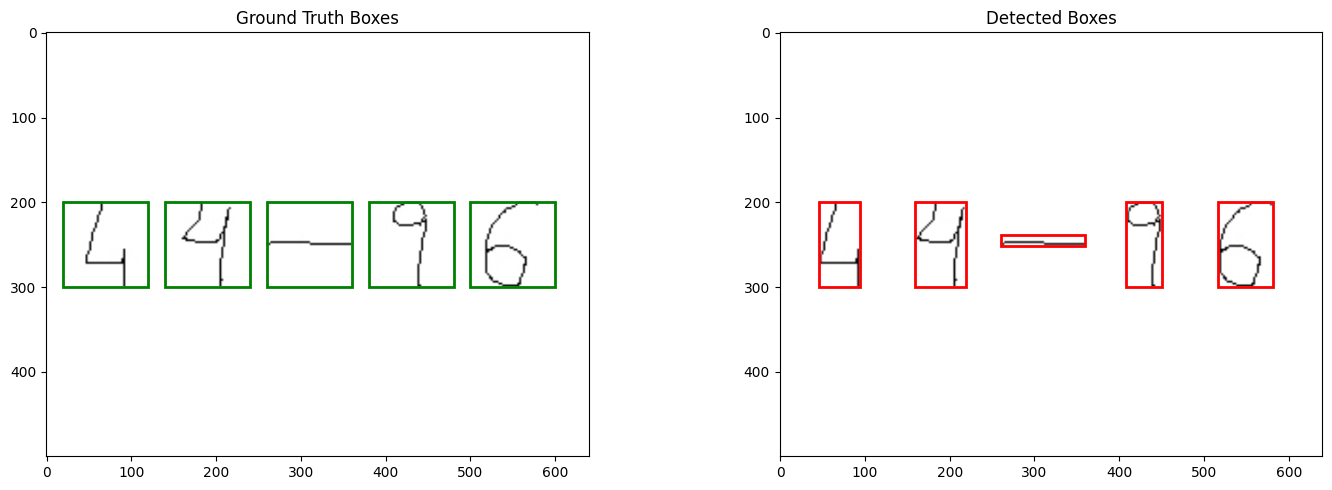

NameError: name 'EQNS' is not defined

In [58]:
# Evaluate single image
image_path = "test_equation_images_withlabels/2numbers_test_035.png"
gt_path = "test_equation_images_withlabels/2numbers_test_035_gt.json"

metrics, ious, detected_boxes, gt_boxes = evaluate_contour_detection(image_path, gt_path)
print("Detection Metrics:", metrics)

# Visualize comparison
visualize_detection_comparison(image_path, detected_boxes, gt_boxes)


# Evaluate all images
all_metrics = []
for i in range(EQNS):
    filename = f"2numbers_test_{str(i).zfill(3)}"
    image_path = f"test_equation_images_withlabels/{filename}.png"
    gt_path = f"test_equation_images_withlabels/{filename}_gt.json"
    
    metrics, _, _, _ = evaluate_contour_detection(image_path, gt_path)
    all_metrics.append(metrics)

# Plot overall metrics
avg_metrics = plot_detection_metrics(all_metrics)
print("\nAverage Metrics:", avg_metrics)

In [51]:
def calculate_iou(box1, box2):
    """Calculate Intersection over Union for two boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    
    # Calculate intersection coordinates
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)
    
    # Check if there is no intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - intersection_area
    
    iou = intersection_area / union_area
    return iou

def evaluate_detection(detected_boxes, ground_truth_boxes, iou_threshold=0.5):
    """Evaluate detection accuracy"""
    true_positives = 0
    false_positives = len(detected_boxes)
    false_negatives = len(ground_truth_boxes)
    
    for det_box in detected_boxes:
        for gt_box in ground_truth_boxes:
            if calculate_iou(det_box, gt_box) > iou_threshold:
                true_positives += 1
                false_positives -= 1
                false_negatives -= 1
                break
    
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    }

Processed 1 images...
Processed 11 images...
Processed 21 images...
Processed 31 images...
Processed 41 images...

Overall Average IOU: 0.6172


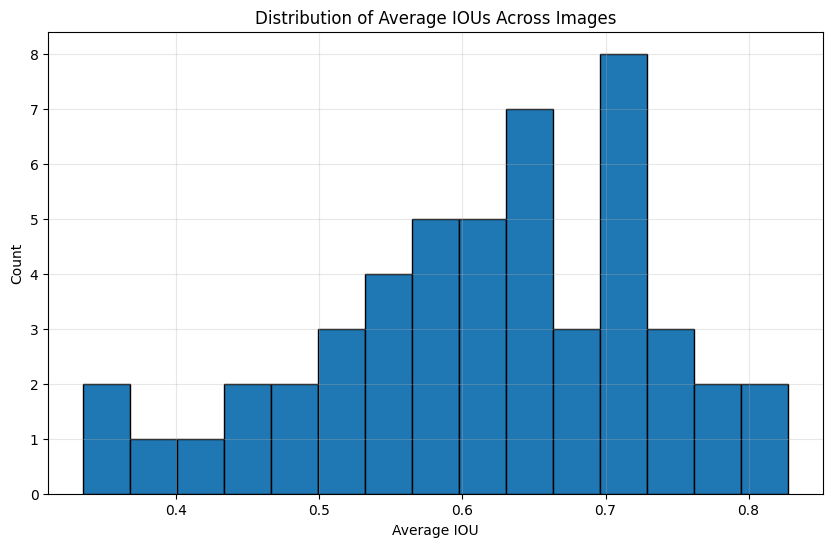

Min IOU: 0.3350
Max IOU: 0.8275
Median IOU: 0.6320
Standard Deviation: 0.1146


In [62]:
def calculate_average_iou_across_images(output_folder, num_images):
   """Calculate the average IOU across all images in the dataset"""
   all_ious = []
   
   for i in range(num_images):
       # Get image and ground truth paths
       filename = f"2numbers_test_{str(i).zfill(3)}"
       image_path = os.path.join(output_folder, f"{filename}.png")
       gt_path = os.path.join(output_folder, f"{filename}_gt.json")
       
       # Get detected boxes
       detected_boxes = detect_contours(image_path)
       
       # Load ground truth boxes
       with open(gt_path, 'r') as f:
           gt_data = json.load(f)
       gt_boxes = gt_data['boxes']
       
       # Calculate IOUs for this image
       image_ious = []
       for det_box in detected_boxes:
           # Find best matching ground truth box
           best_iou = 0
           for gt_box in gt_boxes:
               iou = calculate_iou(det_box, gt_box)
               best_iou = max(best_iou, iou)
           if best_iou > 0:
               image_ious.append(best_iou)
       
       # Add average IOU for this image
       if image_ious:
           all_ious.append(np.mean(image_ious))
           
       if i % 10 == 0:  # Print progress every 10 images
           print(f"Processed {i+1} images...")
   
   # Calculate overall average
   average_iou = np.mean(all_ious)
   print(f"\nOverall Average IOU: {average_iou:.4f}")
   
   return average_iou, all_ious

# Execute for all images
output_folder = "test_equation_images_withlabels"
num_images = 50  # or however many images you generated
avg_iou, all_image_ious = calculate_average_iou_across_images(output_folder, num_images)

# Create a histogram of IOUs
plt.figure(figsize=(10, 6))
plt.hist(all_image_ious, bins=15, edgecolor='black')
plt.title('Distribution of Average IOUs Across Images')
plt.xlabel('Average IOU')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
print(f"Min IOU: {np.min(all_image_ious):.4f}")
print(f"Max IOU: {np.max(all_image_ious):.4f}")
print(f"Median IOU: {np.median(all_image_ious):.4f}")
print(f"Standard Deviation: {np.std(all_image_ious):.4f}")

# Using Different Classifications

In [5]:
import numpy as np
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

def prepare_data(train_generator, validation_generator):
    """Convert generator data to numpy arrays"""
    # Get all training data
    train_images = []
    train_labels = []
    for i in range(len(train_generator)):
        images, labels = train_generator[i]
        train_images.append(images)
        train_labels.append(labels)
    
    X_train = np.concatenate(train_images)
    y_train = np.concatenate(train_labels)
    
    # Get all validation data
    val_images = []
    val_labels = []
    for i in range(len(validation_generator)):
        images, labels = validation_generator[i]
        val_images.append(images)
        val_labels.append(labels)
    
    X_val = np.concatenate(val_images)
    y_val = np.concatenate(val_labels)
    
    # Flatten images for traditional ML models
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    
    # Convert one-hot encoded labels to class indices
    y_train_flat = np.argmax(y_train, axis=1)
    y_val_flat = np.argmax(y_val, axis=1)
    
    return X_train_flat, y_train_flat, X_val_flat, y_val_flat

def create_simple_nn():
    """Create a simple neural network without convolutions"""
    model = tf.keras.Sequential([
        tf.keras.layers.Input((45*45,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(14, activation='softmax')
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

def evaluate_models(X_train, y_train, X_val, y_val, class_names):
    """Train and evaluate multiple models"""
    models = {
        'SVM': SVC(kernel='rbf', probability=True),
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'k-NN': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier(),
        'Simple NN': create_simple_nn()
    }
    
    results = {
        'accuracy': [],
        'training_time': [],
        'inference_time': [],
        'model_name': []
    }
    
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Training time
        start_time = time.time()
        if name == 'Simple NN':
            model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0)
        else:
            model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time
        
        # Inference time
        start_time = time.time()
        if name == 'Simple NN':
            y_pred = np.argmax(model.predict(X_val_scaled), axis=1)
        else:
            y_pred = model.predict(X_val_scaled)
        inference_time = time.time() - start_time
        
        # Accuracy
        accuracy = accuracy_score(y_val, y_pred)
        
        results['model_name'].append(name)
        results['accuracy'].append(accuracy)
        results['training_time'].append(training_time)
        results['inference_time'].append(inference_time)
        
        print(f"{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Inference time: {inference_time:.2f} seconds")
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred, target_names=class_names))
    
    return results

def plot_comparison_results(results):
    """Create visualizations comparing model performance"""
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Accuracy comparison
    sns.barplot(x='model_name', y='accuracy', data=results, ax=axes[0])
    axes[0].set_title('Model Accuracy Comparison')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_ylabel('Accuracy')
    
    # Time comparison
    metrics_df = pd.DataFrame({
        'Training Time': results['training_time'],
        'Inference Time': results['inference_time']
    }, index=results['model_name'])
    
    metrics_df.plot(kind='bar', ax=axes[1])
    axes[1].set_title('Model Time Comparison')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Time (seconds)')
    axes[1].legend()
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

# Main execution
def run_model_comparison(train_generator, validation_generator, class_names):
    # Prepare data
    X_train, y_train, X_val, y_val = prepare_data(train_generator, validation_generator)
    
    # Evaluate models
    results = evaluate_models(X_train, y_train, X_val, y_val, class_names)
    
    # Plot results
    plot_comparison_results(results)
    
    return results


Training Random Forest...
Random Forest Results:
Accuracy: 0.4350
Training time: 0.13 seconds
Inference time: 0.00 seconds

Training k-NN...
k-NN Results:
Accuracy: 0.2650
Training time: 0.00 seconds
Inference time: 1.37 seconds

Training Decision Tree...
Decision Tree Results:
Accuracy: 0.2950
Training time: 0.08 seconds
Inference time: 0.00 seconds


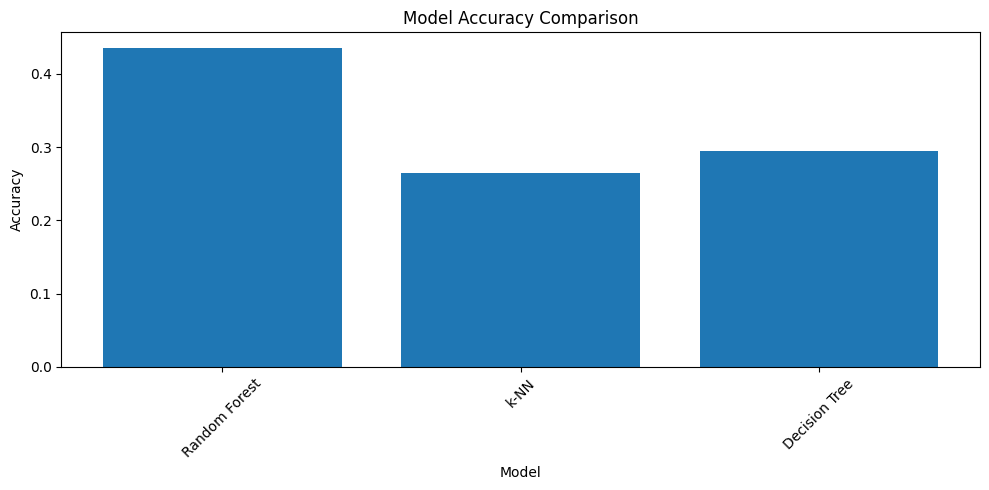


Results Summary:
      model_name  accuracy  training_time  inference_time
0  Random Forest     0.435       0.129008        0.002491
1           k-NN     0.265       0.000933        1.372235
2  Decision Tree     0.295       0.083458        0.000380


In [8]:
import pandas as pd
# First, let's create a smaller dataset from our generators
def get_small_dataset(generator, num_samples=5000):
    generator.reset()
    images = []
    labels = []
    samples_collected = 0
    
    for i in range(len(generator)):
        if samples_collected >= num_samples:
            break
        batch_x, batch_y = generator[i]
        space_left = num_samples - samples_collected
        images.append(batch_x[:space_left])
        labels.append(batch_y[:space_left])
        samples_collected += len(batch_x[:space_left])
    
    X = np.concatenate(images)
    y = np.concatenate(labels)
    return X.reshape(X.shape[0], -1), np.argmax(y, axis=1)

# Get smaller datasets
X_train, y_train = get_small_dataset(train_generator, num_samples=1000)
X_val, y_val = get_small_dataset(validation_generator, num_samples=200)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Define and evaluate simpler models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=10),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Decision Tree': DecisionTreeClassifier(max_depth=10)
}

results = {
    'model_name': [],
    'accuracy': [],
    'training_time': [],
    'inference_time': []
}

# Evaluate each model
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Training time
    start_time = time.time()
    model.fit(X_train_scaled, y_train)
    training_time = time.time() - start_time
    
    # Inference time
    start_time = time.time()
    y_pred = model.predict(X_val_scaled)
    inference_time = time.time() - start_time
    
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    
    results['model_name'].append(name)
    results['accuracy'].append(accuracy)
    results['training_time'].append(training_time)
    results['inference_time'].append(inference_time)
    
    print(f"{name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Inference time: {inference_time:.2f} seconds")

# Plot results
plt.figure(figsize=(10, 5))
plt.bar(results['model_name'], results['accuracy'])
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compare with your CNN results
results_df = pd.DataFrame(results)
print("\nResults Summary:")
print(results_df)

In [9]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def prepare_full_data(train_generator, validation_generator):
    """Convert full generator data to numpy arrays"""
    print("Preparing training data...")
    train_images = []
    train_labels = []
    for i in range(len(train_generator)):
        images, labels = train_generator[i]
        train_images.append(images)
        train_labels.append(labels)
    
    X_train = np.concatenate(train_images)
    y_train = np.concatenate(train_labels)
    
    print("Preparing validation data...")
    val_images = []
    val_labels = []
    for i in range(len(validation_generator)):
        images, labels = validation_generator[i]
        val_images.append(images)
        val_labels.append(labels)
    
    X_val = np.concatenate(val_images)
    y_val = np.concatenate(val_labels)
    
    # Flatten images for traditional ML models
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    
    # Convert one-hot encoded labels to class indices
    y_train_flat = np.argmax(y_train, axis=1)
    y_val_flat = np.argmax(y_val, axis=1)
    
    return X_train_flat, y_train_flat, X_val_flat, y_val_flat

def plot_confusion_matrix(y_true, y_pred, class_names, title):
    """Plot confusion matrix for a model"""
    plt.figure(figsize=(12, 10))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.title(f'Confusion Matrix - {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

def plot_class_accuracies(y_true, y_pred, class_names, title):
    """Plot per-class accuracy for a model"""
    accuracies = []
    for i in range(len(class_names)):
        mask = y_true == i
        if mask.sum() > 0:
            acc = (y_pred[mask] == i).mean()
            accuracies.append(acc)
        else:
            accuracies.append(0)
    
    plt.figure(figsize=(15, 5))
    bars = plt.bar(class_names, accuracies)
    plt.title(f'Per-Class Accuracy - {title}')
    plt.xlabel('Class')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2%}',
                ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

def evaluate_and_visualize_models(X_train, y_train, X_val, y_val, class_names):
    """Train, evaluate and create visualizations for multiple models"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'k-NN': KNeighborsClassifier(n_neighbors=5),
        'Decision Tree': DecisionTreeClassifier()
    }
    
    results = {
        'accuracy': [],
        'training_time': [],
        'inference_time': [],
        'model_name': []
    }
    
    # Scale the data
    print("Scaling data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Training time
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time
        
        # Inference time
        start_time = time.time()
        y_pred = model.predict(X_val_scaled)
        inference_time = time.time() - start_time
        
        # Metrics
        accuracy = accuracy_score(y_val, y_pred)
        
        results['model_name'].append(name)
        results['accuracy'].append(accuracy)
        results['training_time'].append(training_time)
        results['inference_time'].append(inference_time)
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Inference time: {inference_time:.2f} seconds")
        
        # Create visualizations for each model
        print(f"\nGenerating visualizations for {name}...")
        plot_confusion_matrix(y_val, y_pred, class_names, name)
        plot_class_accuracies(y_val, y_pred, class_names, name)
        
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred, target_names=class_names))
    
    # Plot overall comparison
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Accuracy comparison
    sns.barplot(x='model_name', y='accuracy', data=pd.DataFrame(results), ax=ax1)
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('Accuracy')
    
    # Time comparison
    time_df = pd.DataFrame({
        'Training Time': results['training_time'],
        'Inference Time': results['inference_time']
    }, index=results['model_name'])
    
    time_df.plot(kind='bar', ax=ax2)
    ax2.set_title('Model Time Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Time (seconds)')
    ax2.legend()
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Main execution
def run_full_comparison(train_generator, validation_generator, class_names):
    """Run the full comparison with visualizations"""
    # Prepare full dataset
    X_train, y_train, X_val, y_val = prepare_full_data(train_generator, validation_generator)
    
    # Run evaluation and create visualizations
    results = evaluate_and_visualize_models(X_train, y_train, X_val, y_val, class_names)
    
    return results

Preparing training data...
Preparing validation data...
Scaling data...

Training Random Forest...

Random Forest Results:
Accuracy: 0.8839
Training time: 25.85 seconds
Inference time: 0.43 seconds

Generating visualizations for Random Forest...


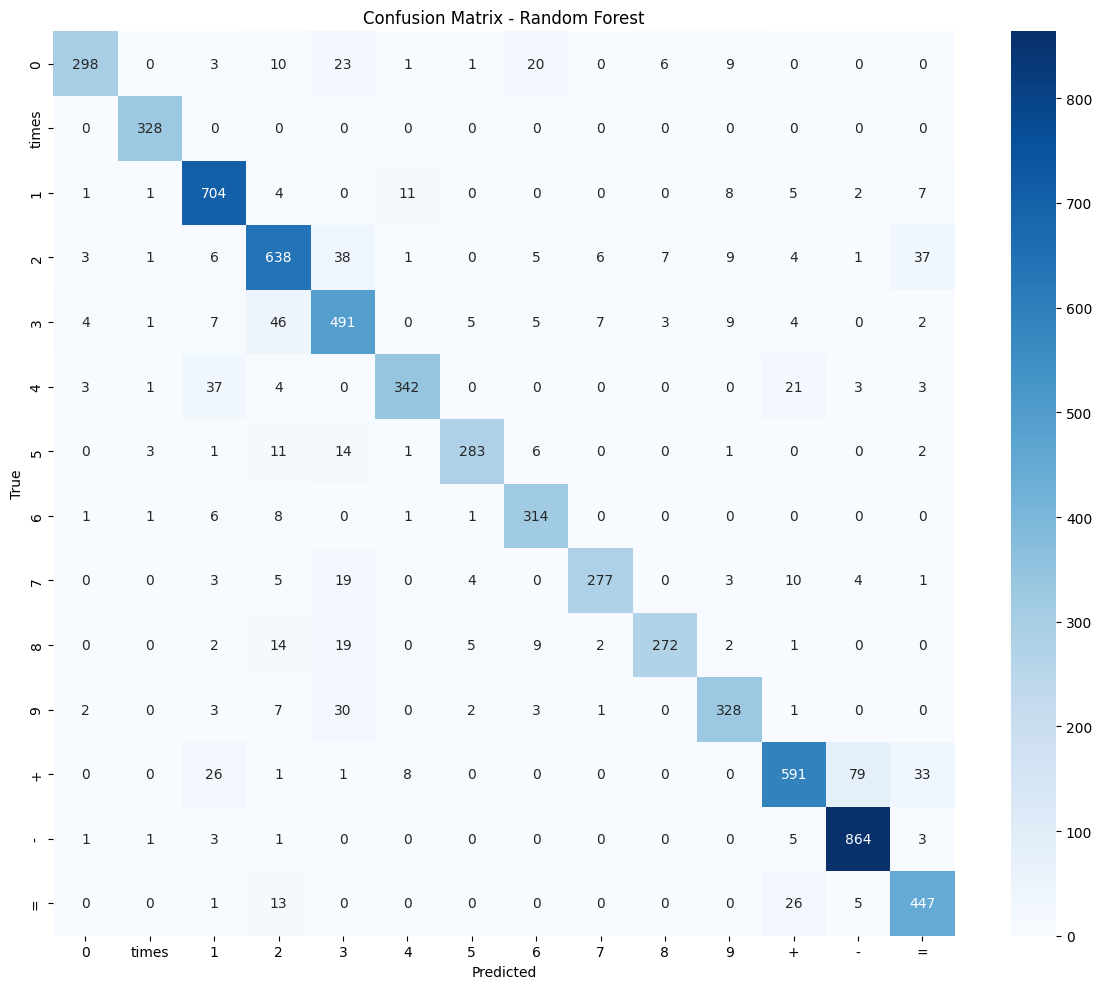

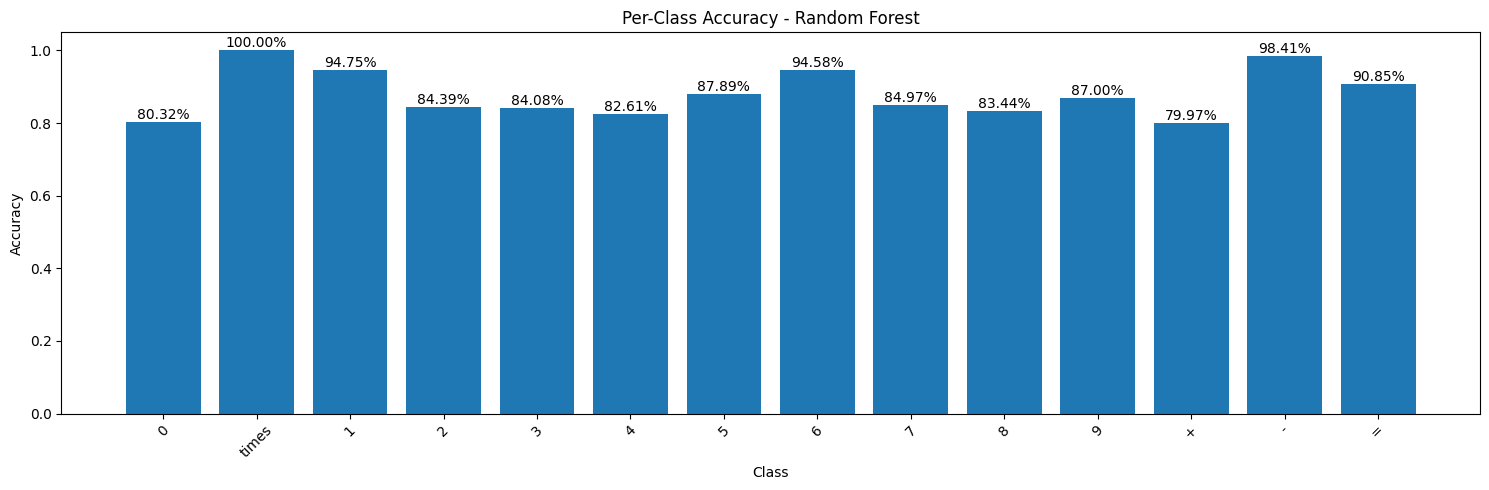


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.80      0.87       371
       times       0.97      1.00      0.99       328
           1       0.88      0.95      0.91       743
           2       0.84      0.84      0.84       756
           3       0.77      0.84      0.81       584
           4       0.94      0.83      0.88       414
           5       0.94      0.88      0.91       322
           6       0.87      0.95      0.90       332
           7       0.95      0.85      0.89       326
           8       0.94      0.83      0.89       326
           9       0.89      0.87      0.88       377
           +       0.88      0.80      0.84       739
           -       0.90      0.98      0.94       878
           =       0.84      0.91      0.87       492

    accuracy                           0.88      6988
   macro avg       0.90      0.88      0.89      6988
weighted avg       0.89      0.88      0.88      6988




In [ ]:
# Run the full comparison
results = run_full_comparison(train_generator, validation_generator, class_names)

# View detailed results
results_df = pd.DataFrame(results)
print("\nDetailed Results:")
print(results_df)

Preparing training data...
Processing data in batches...
Processed 10 batches...
Processed 20 batches...
Processed 30 batches...
Processed 40 batches...
Processed 50 batches...
Processed 60 batches...
Processed 70 batches...
Processed 80 batches...
Processed 90 batches...
Processed 100 batches...
Processed 110 batches...
Processed 120 batches...
Processed 130 batches...
Processed 140 batches...
Processed 150 batches...
Processed 160 batches...
Processed 170 batches...
Processed 180 batches...
Processed 190 batches...
Processed 200 batches...
Processed 210 batches...
Processed 220 batches...
Processed 230 batches...
Processed 240 batches...
Processed 250 batches...
Processed 260 batches...
Processed 270 batches...
Processed 280 batches...
Processed 290 batches...
Processed 300 batches...
Processed 310 batches...
Processed 320 batches...
Processed 330 batches...
Processed 340 batches...
Processed 350 batches...
Processed 360 batches...
Processed 370 batches...
Processed 380 batches...
Pr

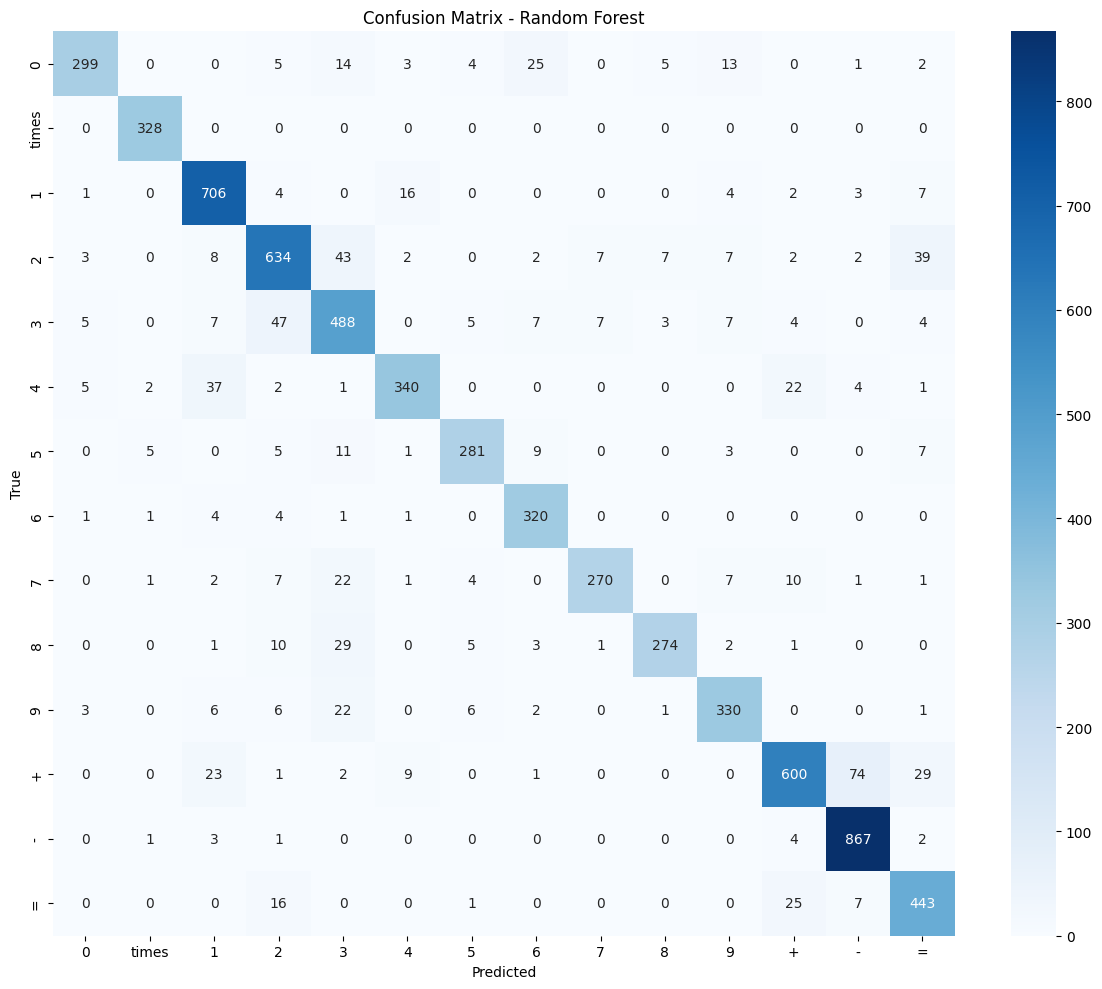

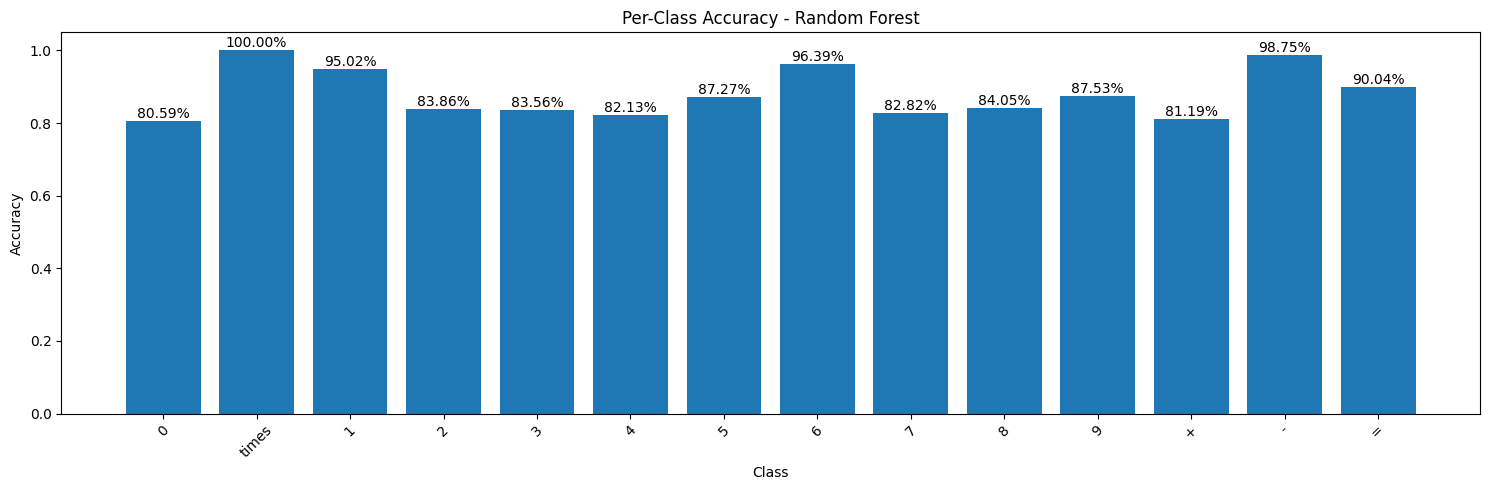


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       371
       times       0.97      1.00      0.98       328
           1       0.89      0.95      0.92       743
           2       0.85      0.84      0.85       756
           3       0.77      0.84      0.80       584
           4       0.91      0.82      0.86       414
           5       0.92      0.87      0.89       322
           6       0.87      0.96      0.91       332
           7       0.95      0.83      0.88       326
           8       0.94      0.84      0.89       326
           9       0.88      0.88      0.88       377
           +       0.90      0.81      0.85       739
           -       0.90      0.99      0.94       878
           =       0.83      0.90      0.86       492

    accuracy                           0.88      6988
   macro avg       0.89      0.88      0.89      6988
weighted avg       0.89      0.88      0.88      6988




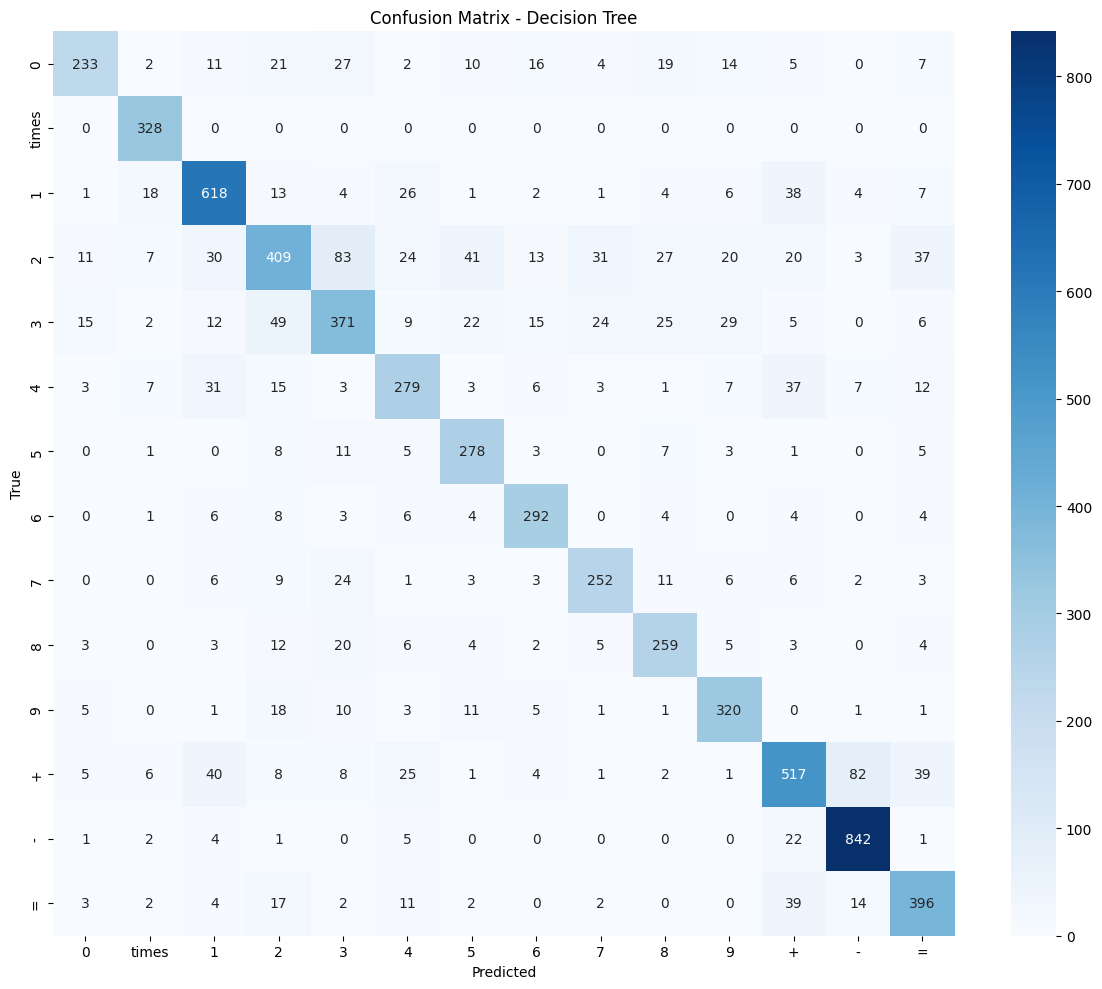

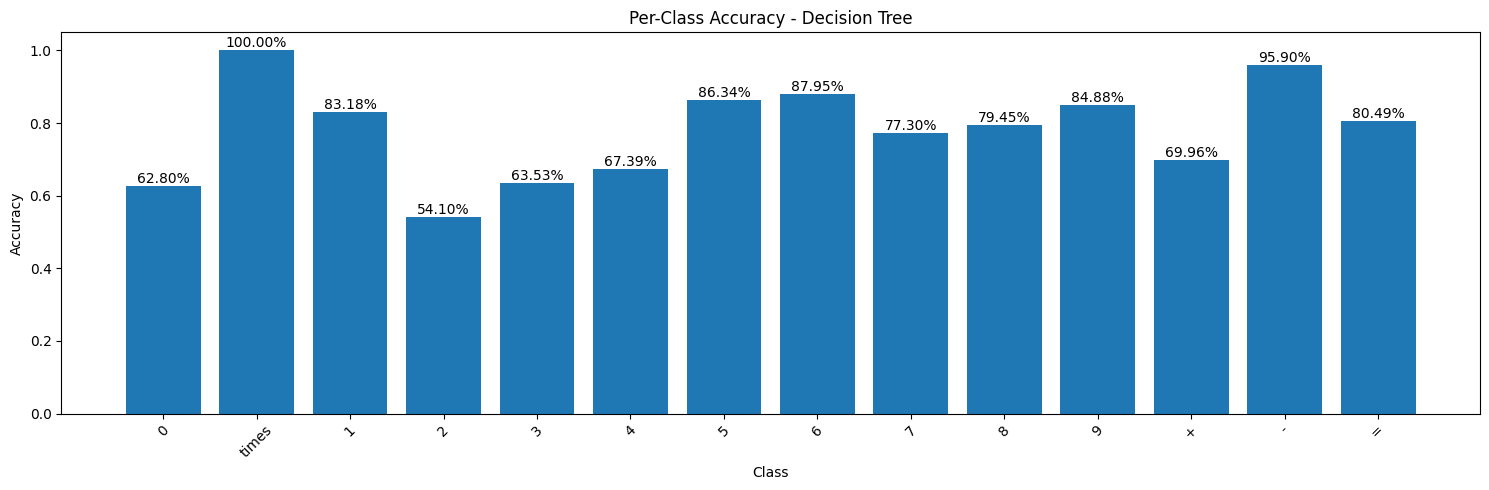


Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.63      0.72       371
       times       0.87      1.00      0.93       328
           1       0.81      0.83      0.82       743
           2       0.70      0.54      0.61       756
           3       0.66      0.64      0.65       584
           4       0.69      0.67      0.68       414
           5       0.73      0.86      0.79       322
           6       0.81      0.88      0.84       332
           7       0.78      0.77      0.78       326
           8       0.72      0.79      0.76       326
           9       0.78      0.85      0.81       377
           +       0.74      0.70      0.72       739
           -       0.88      0.96      0.92       878
           =       0.76      0.80      0.78       492

    accuracy                           0.77      6988
   macro avg       0.77      0.78      0.77      6988
weighted avg       0.77      0.77      0.77      6988



/tmp/ipykernel_4002110/52493415.py:134: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


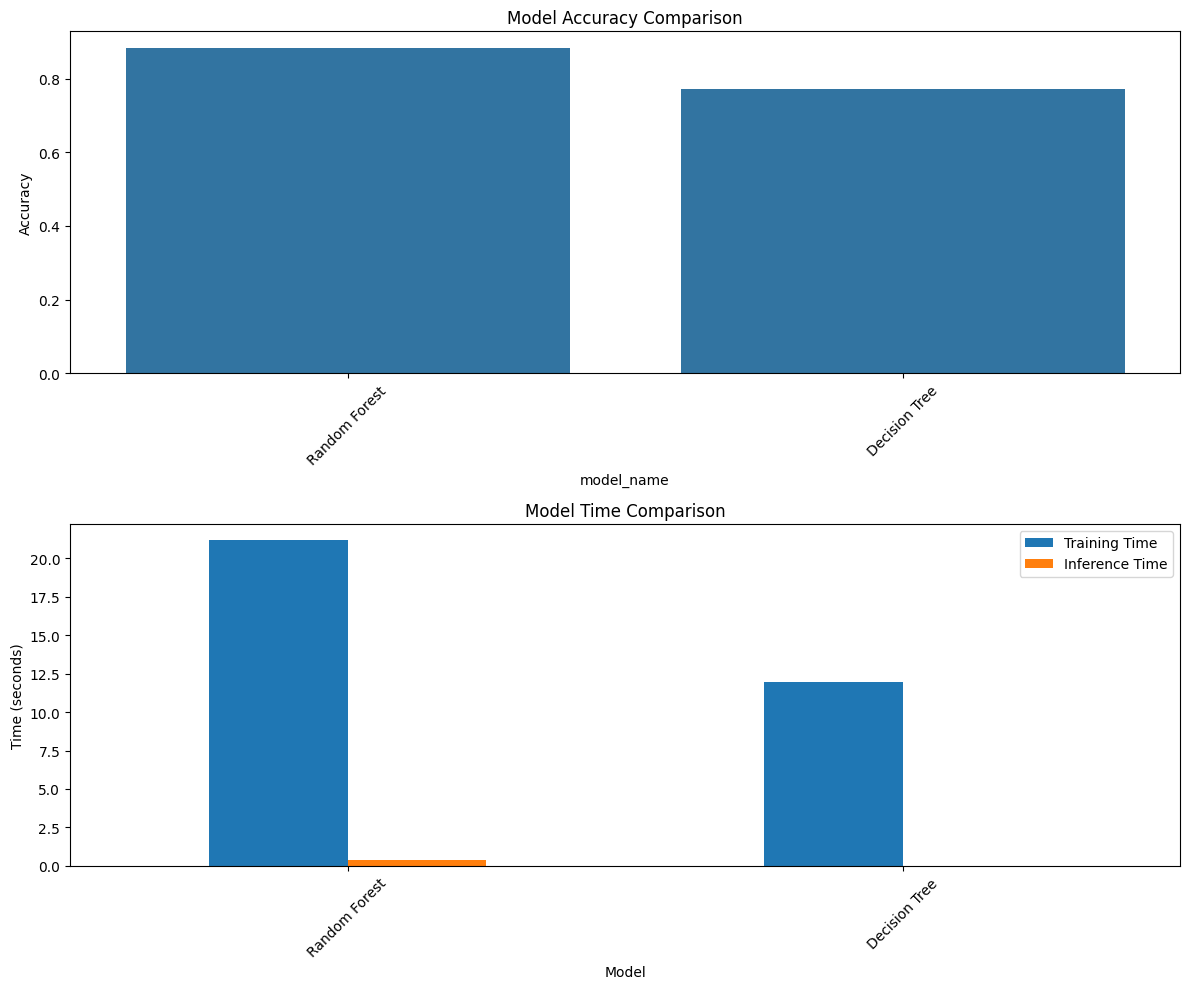

In [8]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import gc  # For garbage collection

def prepare_data_in_batches(generator, batch_size=1000):
    """Process data in smaller batches to manage memory"""
    all_data = []
    all_labels = []
    
    print("Processing data in batches...")
    generator.reset()
    for i in range(len(generator)):
        batch_x, batch_y = generator[i]
        # Flatten the images
        batch_x_flat = batch_x.reshape(batch_x.shape[0], -1)
        all_data.append(batch_x_flat)
        all_labels.append(np.argmax(batch_y, axis=1))
        
        if (i + 1) % 10 == 0:
            print(f"Processed {i + 1} batches...")
    
    X = np.concatenate(all_data)
    y = np.concatenate(all_labels)
    
    # Clear some memory
    del all_data, all_labels
    gc.collect()
    
    return X, y

def evaluate_and_visualize_models(X_train, y_train, X_val, y_val, class_names):
    """Train and evaluate Random Forest and Decision Tree"""
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100),
        'Decision Tree': DecisionTreeClassifier()
    }
    
    results = {
        'accuracy': [],
        'training_time': [],
        'inference_time': [],
        'model_name': []
    }
    
    # Scale the data
    print("Scaling data...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Training time
        start_time = time.time()
        model.fit(X_train_scaled, y_train)
        training_time = time.time() - start_time
        
        # Inference time
        start_time = time.time()
        y_pred = model.predict(X_val_scaled)
        inference_time = time.time() - start_time
        
        # Metrics
        accuracy = accuracy_score(y_val, y_pred)
        
        results['model_name'].append(name)
        results['accuracy'].append(accuracy)
        results['training_time'].append(training_time)
        results['inference_time'].append(inference_time)
        
        print(f"\n{name} Results:")
        print(f"Accuracy: {accuracy:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
        print(f"Inference time: {inference_time:.2f} seconds")
        
        # Confusion Matrix
        plt.figure(figsize=(12, 10))
        cm = confusion_matrix(y_val, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.title(f'Confusion Matrix - {name}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()
        
        # Per-class accuracy
        accuracies = []
        for i in range(len(class_names)):
            mask = y_val == i
            if mask.sum() > 0:
                acc = (y_pred[mask] == i).mean()
                accuracies.append(acc)
            else:
                accuracies.append(0)
        
        plt.figure(figsize=(15, 5))
        bars = plt.bar(class_names, accuracies)
        plt.title(f'Per-Class Accuracy - {name}')
        plt.xlabel('Class')
        plt.ylabel('Accuracy')
        plt.xticks(rotation=45)
        
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2%}',
                    ha='center', va='bottom')
        
        plt.tight_layout()
        plt.show()
        
        print("\nClassification Report:")
        print(classification_report(y_val, y_pred, target_names=class_names))
        
        # Clear some memory
        gc.collect()
    
    # Overall comparison plots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
    
    # Accuracy comparison
    sns.barplot(x='model_name', y='accuracy', data=pd.DataFrame(results), ax=ax1)
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    ax1.set_ylabel('Accuracy')
    
    # Time comparison
    time_df = pd.DataFrame({
        'Training Time': results['training_time'],
        'Inference Time': results['inference_time']
    }, index=results['model_name'])
    
    time_df.plot(kind='bar', ax=ax2)
    ax2.set_title('Model Time Comparison')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('Time (seconds)')
    ax2.legend()
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return results

# Main execution
def run_comparison(train_generator, validation_generator, class_names):
    """Run the full comparison with visualizations"""
    # Prepare data
    print("Preparing training data...")
    X_train, y_train = prepare_data_in_batches(train_generator)
    print("Preparing validation data...")
    X_val, y_val = prepare_data_in_batches(validation_generator)
    
    # Run evaluation and create visualizations
    results = evaluate_and_visualize_models(X_train, y_train, X_val, y_val, class_names)
    
    return results

# Run the comparison
results = run_comparison(train_generator, validation_generator, class_names)